# Series de tiempo

In [2]:
# Llamado de librerias
library(dplyr)
library(ggplot2)
library(patchwork)
library(forecast)
library(tseries)
library(scales)
library(gridExtra)
library(reshape)
library(matlib)

In [3]:
# Importando archivo .csv
File = read.csv(file = ('../Ejercicio inflación/Inflación.csv'), skip = 0, header = TRUE)
head(File)
sprintf('El número de observaciones son: %s', length(File[, 1]))

,Fecha,Inflacion
,<chr>,<dbl>
1,1/31/2001,8.4922
2,2/28/2001,8.0583
3,3/31/2001,7.8143
4,4/30/2001,7.9759
5,5/31/2001,7.8654
6,6/30/2001,7.9298


[1] "El número de observaciones son: 216"

## Inputs

In [4]:
# Inputs 
K = 36                                          # 'Truncado' para (T / 4), si no ingrese el valor numérico
alpha = 0.05                                    # Nivel de significancia

# Desestacionalización
k = 12                                          # Coeficiente de medias moviles y estacionalidad

# Estabilización de la varianza
R = 12                                          # Total de observaciones por grupo o división
Lambdas = c(-1, -0.5, 0, 0.5, 1)                # Vector de Lambdas c(2, 1, 0.5, 0, -0.5, -1, -2)   

# Esabilización de nivel
K.Dif = 3                                       # Diferenciación de la estabilización de nivel, normalmente no se requiere diferenciaciones (rezago) de grado más alto

# Parámetros y transformaciones lineales
X = File$Inflacion

# Datos a pronosticar
P = 24

## Variables y condicionales

,K,X
,<dbl>,<dbl>
1,1,8.4922
2,2,8.0583
3,3,7.8143
4,4,7.9759
5,5,7.8654
6,6,7.9298


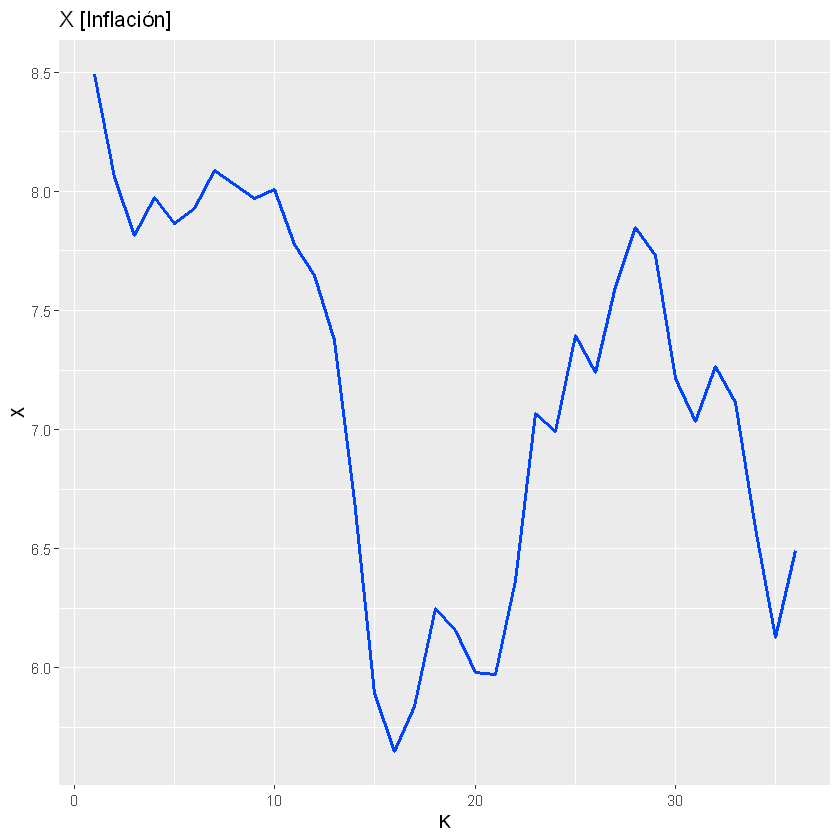

In [8]:
# Construcción de los vectores y parámetros
X = cbind(X)
T = length(X)

# Condición de K
if (K == 'Truncado'){
    K = length(File[, 1]) / 4
} else {
    K = K
}

# Función para verificar si un número es entero o no
is.wholenumber <- function(x, tol = .Machine$double.eps ** 0.5)abs(x - round(x)) < tol             # TRUE = Entero, FALSE = Decimal

# Redefinición de los datos
X.r = matrix(data = X, nrow = 12)
if (is.wholenumber(T / R) == 'FALSE'){
  H = floor(T / R)
  if (T > (H * R)){                                     # Llenar de NA los datos que se repiten al no ser múltiplo de R la matriz
    l = T - (H * R)
    X.r[((l + 1) : R), (H + 1)] = NA
  }
} else if (is.wholenumber(T / R) == 'TRUE'){
  H = T / R
  X.r = matrix(data = X, nrow = 12)
}

# Fechas
Dates = as.matrix(File[, 1])
Dates1 = as.Date(Dates, '%m/%d/%Y')


# Gráfica de los datos
XI = data.frame(matrix(data = NA, nrow = K, ncol = 2))  
colnames(XI) = c('K', 'X')
XI[, 1] = seq(1, K, 1)
XI[, 2] = X[1 : K]
XI = with(XI, data.frame(K, X))

G_X <- ggplot(data = XI, mapping = aes(x = K, y = X)) +
  geom_line(colour = '#0044ff', size = 1) +
  labs(title = 'X [Inflación]')
        
# Salidas 
head(XI)
G_X

## Desestacionalización de la serie
- **Tendencia:** Es un patrón a largo plazo, relativamente suave, exhibido por la serie a través del tiempo. Este se caracteriza por su patrón gradual y consistente que presenta variaciones propias de la serie lo cual es producto de las fuerzas persistentes que afectan el crecimiento o la reducción.
- **Estacionalidad:** Es un patrón de la serie que exhibe a intervalos regulares de tiempo dentro del año. Esta asociado con estaciones o movimientos que se dan en los mismos meses año tras año.
- **Componente aleatorio:** Es el componente resultante de extraer de la serie de tiempo, los 3 componentes anteriores. Estos son factores de corto plazo, imprevisible y no recurrentes que afectan a la serie de tiempo.
- **Serie de tiempo:** Conjunto de variables aleatorias indexadas a través del tiempo que miden el mismo fenómeno macroeconómico.

            X
[1,] 3.441051
[2,] 3.100495
[3,] 2.941455
[4,] 3.134286
[5,] 3.039410
[6,] 3.092218


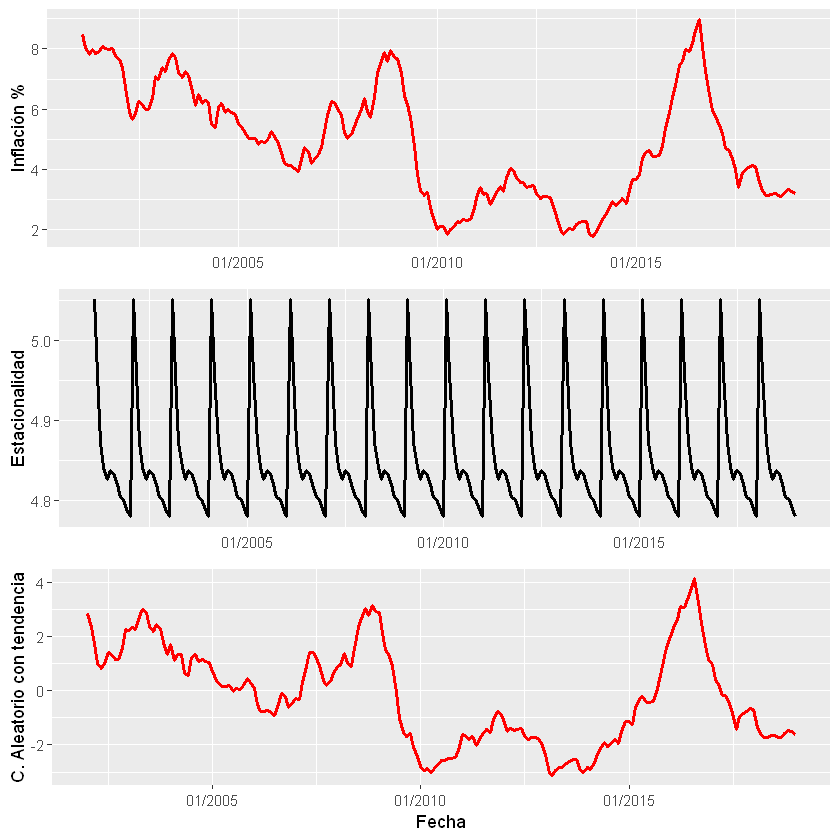

In [9]:
# Cálculo del componente estacional 
Estacional1y <- matrix(data = NA, ncol = 1, nrow = k)
for(i in 1 : k){
  Estacional1y[i] = mean(X[seq(from = i, to = floor(T / k) * k, by = k)])
}
Estac_1y <- matrix(data = Estacional1y, ncol = 1, nrow = T)

# Cálculo del componente aleatorio con tendencia
C_Aleatorio = X - Estac_1y

# Salidas gráficas
XTs = data.frame(matrix(data = NA, nrow = length(X), ncol = 2))           # Datos del archivo
colnames(XTs) = c('K', 'X')
XTs[, 1] = Dates1[1 : length(X)]
XTs[, 2] = X

G_XTs <- ggplot(data = XTs, mapping = aes(x = K, y = X)) +
  geom_line(colour = 'red', size = 1) +
  labs(x = 'Fecha', y = 'Inflación %') +
  scale_x_date(labels = date_format("%m/%Y")) +
  theme(axis.title.x=element_blank(),
        axis.ticks.x=element_blank())

XSt = data.frame(matrix(data = NA, nrow = length(Estac_1y), ncol = 2))           # Datos de la estacionalidad
colnames(XSt) = c('K', 'X')
XSt[, 1] = Dates1[1 : length(Estac_1y)]
XSt[, 2] = Estac_1y[1 : length(Estac_1y)]


G_XSt <- ggplot(data = XSt, mapping = aes(x = K, y = X)) +
  geom_line(colour = 'black', size = 1) +
  labs(x = 'Fecha', y = 'Estacionalidad') +
  scale_x_date(labels = date_format("%m/%Y")) +
  theme(axis.title.x=element_blank(),
        axis.ticks.x=element_blank())

X_Ca = data.frame(matrix(data = NA, nrow = (length(C_Aleatorio) - (k - 1)), ncol = 2))                   # Datos componente aleatorio
colnames(X_Ca) = c('K', 'X')
X_Ca[, 1] = Dates1[k : length(C_Aleatorio)]
X_Ca[, 2] = C_Aleatorio[k : length(C_Aleatorio)]

G_XCa <- ggplot(data = X_Ca, mapping = aes(x = K, y = X)) +
  geom_line(colour = 'red', size = 1) +
  labs(x = 'Fecha', y = 'C. Aleatorio con tendencia') +
  scale_x_date(labels = date_format("%m/%Y"))

# Salidas gráficas
grid.arrange(G_XTs, G_XSt , G_XCa, nrow = 3)

X.data = C_Aleatorio

print(head(C_Aleatorio))

## Prueba de raíz unitaria

### Simulación de las distribuciones

#### Tau

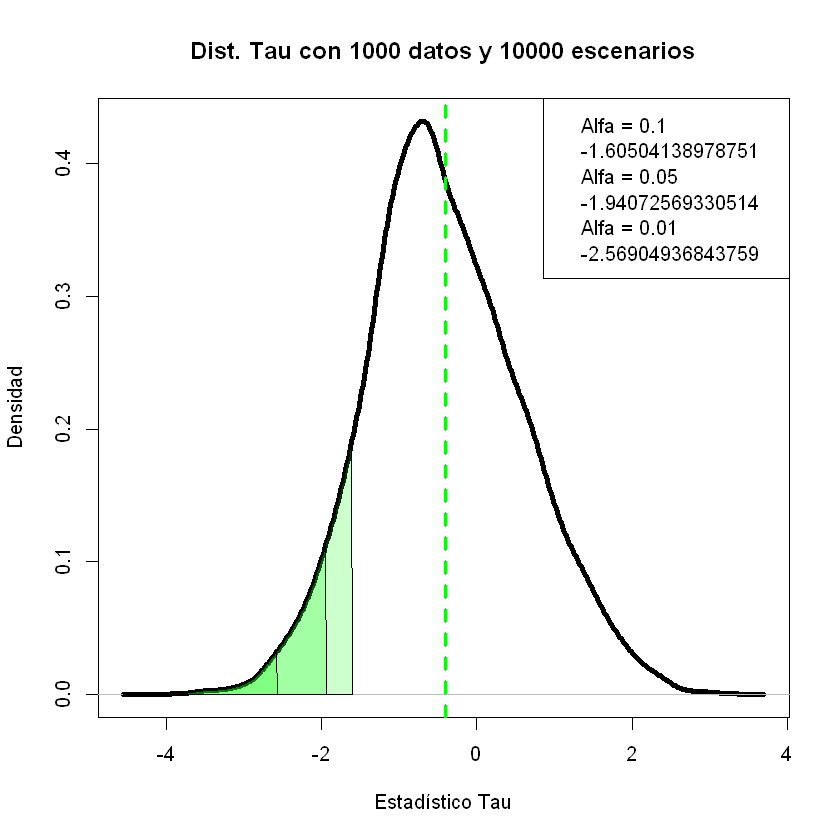

In [11]:
Tau_G = function(T, S, Z_0 = 0, Sigma_a = 1, Plot = FALSE){  
  Zt <- c(Z_0)                                                    #Creando matriz con el valor inicial

  #Creando una matriz vacía para almacenar los estadísticos
  Tau = matrix(data = NA, nrow = S, ncol = 1)

  for (n in 1 : S){
    #Generando los errores
    set.seed(n)
    At <- rnorm(n = T ,mean = 0, sd = Sigma_a)

    #Corriendo la función generadora del PGD
    for(t in 2 : T){
      Zt[t] = Zt[t - 1] + At[t]
    }

    #Calculando la serie diferenciada
    Diferencia = function(Data){                                 # Operador de diferencia
        Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
        for(i in 1 : (T - 1)){
            Serie.dif[i] <- Data[i + 1] - Data[i]
        }
        return(Serie.dif)
    }
    X.Diff = Diferencia(Data = Zt)

    #Calculando la serie rezagada
    X.Rez <- Zt[1 : (T - 1)]
    
    #Estimando la regresión (OLS)
    Y = X.Diff
    X = cbind(X.Rez)
    Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)
    Gamma = Coeff[1]                                               # Coeficiente Gamma estimado

    # Estimación sigma^2 (Beta moño de OLS)
    Ym = X %*% Coeff
    Em = Y - Ym
    Sigma2 = as.numeric((t(Em) %*% Em) / (T - 1))
    Var.cov = (Sigma2 * solve(t(X) %*% X))
    Gamma_std = sqrt(Var.cov[1, 1])
    
    #Llenando la matriz
    Tau[n] <- Gamma / Gamma_std
  }

  # Quantiles
  Q_T = matrix(data = c(quantile(Tau, probs = 0.1), quantile(Tau, probs = 0.05), quantile(Tau, probs = 0.01)), ncol = 3, nrow = 1)
  colnames(Q_T) = c('10%', '5%', '1%')
  value2 = Q_T[, 1]
  value3 = Q_T[, 2]
  value4 = Q_T[, 3]

  # Salidas
  if (Plot == FALSE){
    print(Q_T)
  } else {
    # Gráficas
    Den = density(Tau)
    plot(Den, main = sprintf('Dist. Tau con %s datos y %s escenarios', T, S), xlab = "Estadístico Tau", ylab = "Densidad", col = "black", lty = 1, lwd = 4)
    legend(x= "topright" , legend = c("Alfa = 0.1", Q_T[, 1], "Alfa = 0.05", Q_T[, 2], "Alfa = 0.01", Q_T[, 3]))
    polygon(c(Den$x[Den$x <= value2], value2),
        c(Den$y[Den$x <= value2], 0),
        col = rgb(0, 1, 0, alpha = 0.2),
        border = 1)
    polygon(c(Den$x[Den$x <= value3], value3),
      c(Den$y[Den$x <= value3], 0),
      col = rgb(0, 1, 0, alpha = 0.2),
      border = 1)
    polygon(c(Den$x[Den$x <= value4], value4),
        c(Den$y[Den$x <= value4], 0),
        col = rgb(0, 1, 0, alpha = 0.2),
        border = 1)
    abline(v = mean(Tau), col = "green", lwd = 3, lty = 2)
  }
}

Tau_G(T = 1000, S = 10000, Plot = TRUE)

#### Tau ~ Mu

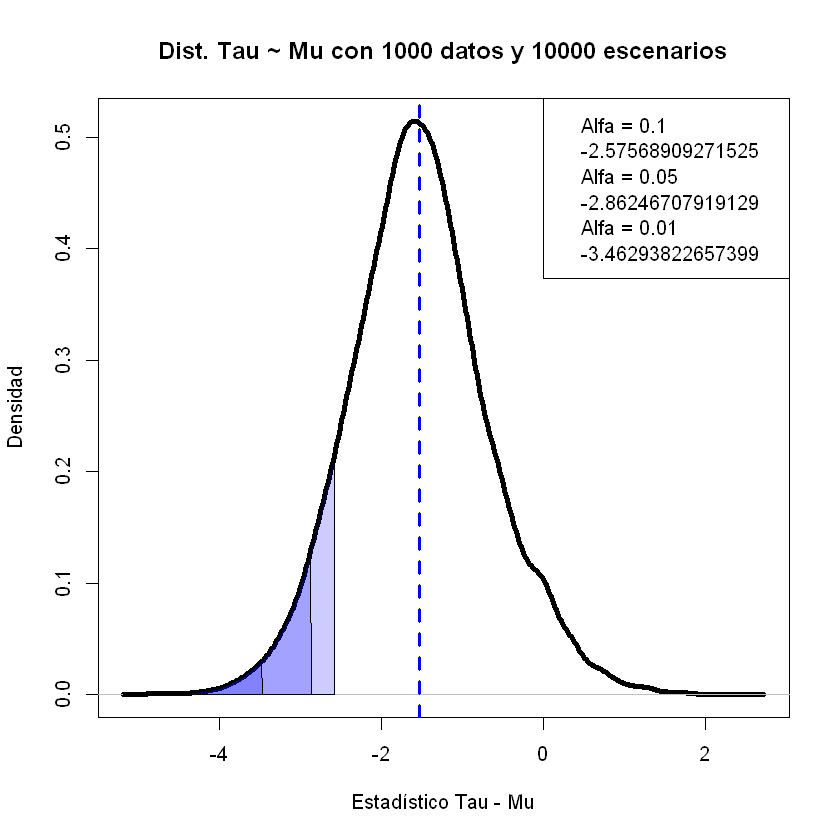

In [4]:
TauM_G = function(T, S, Z_0 = 0, Sigma_a = 1, Plot = FALSE){  
  Zt <- c(Z_0)                                                    #Creando matriz con el valor inicial

  #Creando una matriz vacía para almacenar los estadísticos
  Tau_M = c()

  for (n in 1 : S){
    #Generando los errores
    set.seed(n)
    At <- rnorm(n = T ,mean = 0, sd = Sigma_a)

    #Corriendo la función generadora del PGD
    for(t in 2 : T){
      Zt[t] = Zt[t - 1] + At[t]
    }

    #Calculando la serie diferenciada
    Diferencia = function(Data){                                 # Operador de diferencia
        Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
        for(i in 1 : (T - 1)){
            Serie.dif[i] <- Data[i + 1] - Data[i]
        }
        return(Serie.dif)
    }
    X.Diff = Diferencia(Data = Zt)

    #Calculando la serie rezagada
    X.Rez <- Zt[1 : (T - 1)]
    
    #Estimando la regresión (OLS)
    Y = X.Diff
    X = cbind(1, X.Rez)
    Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)
    Gamma = Coeff[2]                                               # Coeficiente Gamma estimado

    # Estimación sigma^2 (Beta moño de OLS)
    Ym = X %*% Coeff
    Em = Y - Ym
    Sigma2 = as.numeric((t(Em) %*% Em) / (T - 2))
    Var.cov = (Sigma2 * solve(t(X) %*% X))
    Gamma_std = sqrt(Var.cov[2, 2])
    
    #Llenando la matriz
    Tau_M[n] <- Gamma / Gamma_std
  }
  # Quantiles
  Q_TM = matrix(data = c(quantile(Tau_M, probs = 0.1), quantile(Tau_M, probs = 0.05), quantile(Tau_M, probs = 0.01)), ncol = 3, nrow = 1)
  colnames(Q_TM) = c('10%', '5%', '1%')
  value2 = Q_TM[, 1]
  value3 = Q_TM[, 2]
  value4 = Q_TM[, 3]

  # Salidas 
  if (Plot == FALSE){
    print(Q_TM)
  } else {
    
    # Gráficas
    Den = density(Tau_M)
    plot(Den, main = sprintf('Dist. Tau ~ Mu con %s datos y %s escenarios', T, S), xlab="Estadístico Tau - Mu", ylab="Densidad", col="black", lty=1, lwd=4)
    legend(x= "topright" , legend = c("Alfa = 0.1", Q_TM[, 1], "Alfa = 0.05", Q_TM[, 2], "Alfa = 0.01", Q_TM[, 3]))
    polygon(c(Den$x[Den$x <= value2], value2),
        c(Den$y[Den$x <= value2], 0),
        col = rgb(0, 0, 1, alpha = 0.2),
        border = 1)
    polygon(c(Den$x[Den$x <= value3], value3),
      c(Den$y[Den$x <= value3], 0),
      col = rgb(0, 0, 1, alpha = 0.2),
      border = 1)
    polygon(c(Den$x[Den$x <= value4], value4),
        c(Den$y[Den$x <= value4], 0),
        col = rgb(0, 0, 1, alpha = 0.2),
        border = 1)
    abline(v = mean(Tau_M), col = "blue", lwd = 3, lty = 2)
  }
}

TauM_G(T = 1000, S = 10000, Plot = TRUE)

#### Tau ~ Alpha ~ Mu

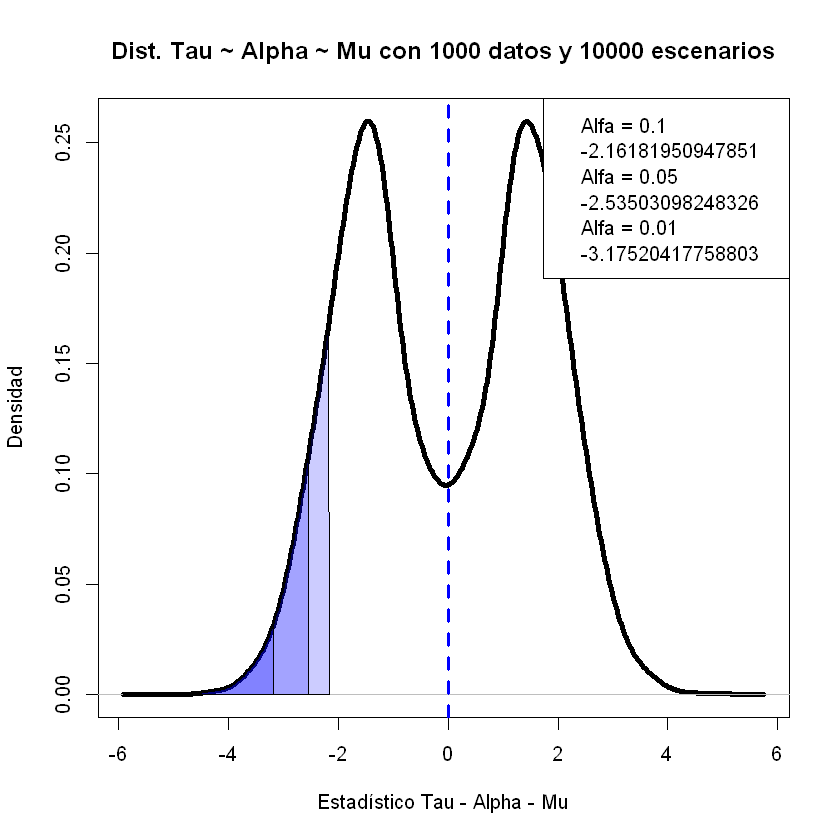

In [5]:
TauAM_G = function(T, S, Z_0 = 0, Sigma_a = 1, Plot = FALSE){  
  Zt <- c(Z_0)                                                    #Creando matriz con el valor inicial

  #Creando una matriz vacía para almacenar los estadísticos
  Tau_M = c()

  for (n in 1 : S){
    #Generando los errores
    set.seed(n)
    At <- rnorm(n = T ,mean = 0, sd = Sigma_a)

    #Corriendo la función generadora del PGD
    for(t in 2 : T){
      Zt[t] = Zt[t - 1] + At[t]
    }

    #Calculando la serie diferenciada
    Diferencia = function(Data){                                 # Operador de diferencia
        Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
        for(i in 1 : (T - 1)){
            Serie.dif[i] <- Data[i + 1] - Data[i]
        }
        return(Serie.dif)
    }
    X.Diff = Diferencia(Data = Zt)

    #Calculando la serie rezagada
    X.Rez <- Zt[1 : (T - 1)]
    
    #Estimando la regresión (OLS)
    Y = X.Diff
    X = cbind(1, X.Rez)
    Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)
    Gamma = Coeff[1]                                               # Coeficiente Gamma estimado

    # Estimación sigma^2 (Beta moño de OLS)
    Ym = X %*% Coeff
    Em = Y - Ym
    Sigma2 = as.numeric((t(Em) %*% Em) / (T - 2))
    Var.cov = (Sigma2 * solve(t(X) %*% X))
    Gamma_std = sqrt(Var.cov[1, 1])
    
    #Llenando la matriz
    Tau_M[n] <- Gamma / Gamma_std
  }
  # Quantiles
  Q_TM = matrix(data = c(quantile(Tau_M, probs = 0.1), quantile(Tau_M, probs = 0.05), quantile(Tau_M, probs = 0.01)), ncol = 3, nrow = 1)
  colnames(Q_TM) = c('10%', '5%', '1%')
  value2 = Q_TM[, 1]
  value3 = Q_TM[, 2]
  value4 = Q_TM[, 3]

  # Salidas 
  if (Plot == FALSE){
    print(Q_TM)
  } else {
    
    # Gráficas
    Den = density(Tau_M)
    plot(Den, main = sprintf('Dist. Tau ~ Alpha ~ Mu con %s datos y %s escenarios', T, S), xlab="Estadístico Tau - Alpha - Mu", ylab="Densidad", col="black", lty=1, lwd=4)
    legend(x= "topright" , legend = c("Alfa = 0.1", Q_TM[, 1], "Alfa = 0.05", Q_TM[, 2], "Alfa = 0.01", Q_TM[, 3]))
    polygon(c(Den$x[Den$x <= value2], value2),
        c(Den$y[Den$x <= value2], 0),
        col = rgb(0, 0, 1, alpha = 0.2),
        border = 1)
    polygon(c(Den$x[Den$x <= value3], value3),
      c(Den$y[Den$x <= value3], 0),
      col = rgb(0, 0, 1, alpha = 0.2),
      border = 1)
    polygon(c(Den$x[Den$x <= value4], value4),
        c(Den$y[Den$x <= value4], 0),
        col = rgb(0, 0, 1, alpha = 0.2),
        border = 1)
    abline(v = mean(Tau_M), col = "blue", lwd = 3, lty = 2)
  }
}

TauAM_G(T = 1000, S = 10000, Plot = TRUE)

#### Tau ~ Tau

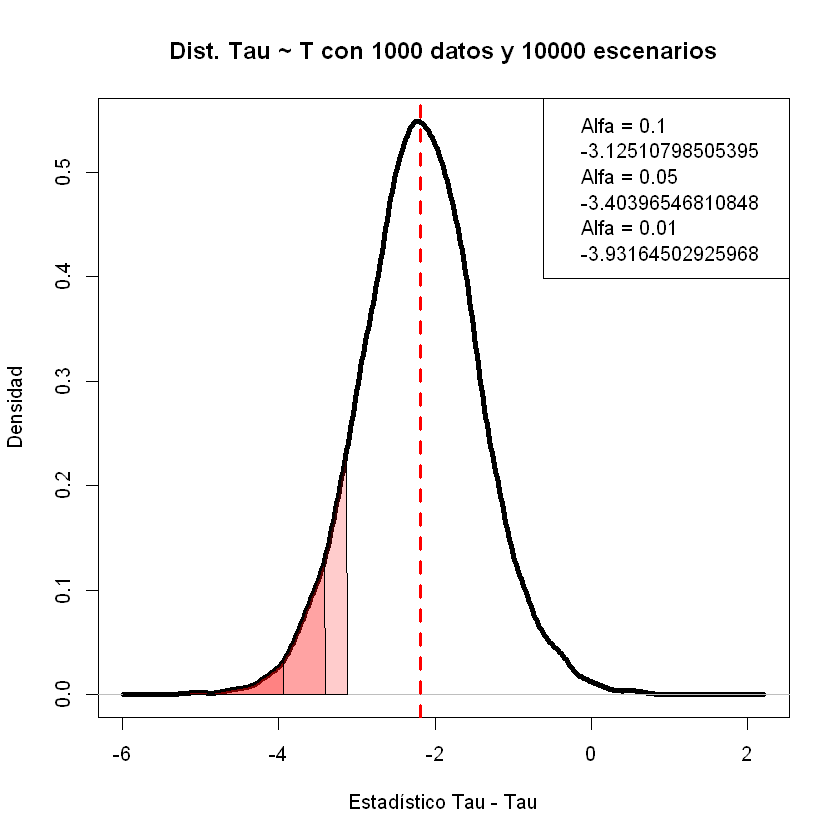

In [6]:
TauT_G = function(T, S, Z_0 = 0, Sigma_a = 1, Plot = FALSE){  
  Zt <- c(Z_0)                                                    #Creando matriz con el valor inicial

  #Creando una matriz vacía para almacenar los estadísticos
  Tau_T = c()

  for (n in 1 : S){
    #Generando los errores
    set.seed(n)
    At <- rnorm(n = T ,mean = 0, sd = Sigma_a)

    #Corriendo la función generadora del PGD
    for(t in 2 : T){
      Zt[t] = Zt[t - 1] + At[t]
    }

    #Calculando la serie diferenciada
    Diferencia = function(Data){                                 # Operador de diferencia
        Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
        for(i in 1 : (T - 1)){
            Serie.dif[i] <- Data[i + 1] - Data[i]
        }
        return(Serie.dif)
    }
    X.Diff = Diferencia(Data = Zt)

    #Calculando la serie rezagada
    X.Rez <- Zt[1 : (T - 1)]
    
    #Estimando la regresión (OLS)
    Y = X.Diff
    X = cbind(1, c(1 : (T - 1)), X.Rez)
    Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)
    Gamma = Coeff[3]                                               # Coeficiente Gamma estimado

    # Estimación sigma^2 (Beta moño de OLS)
    Ym = X %*% Coeff
    Em = Y - Ym
    Sigma2 = as.numeric((t(Em) %*% Em) / (T - 3))
    Var.cov = (Sigma2 * solve(t(X) %*% X))
    Gamma_std = sqrt(Var.cov[3, 3])
    
    #Llenando la matriz
    Tau_T[n] <- Gamma / Gamma_std
  }

  # Quantiles
  Q_TT = matrix(data = c(quantile(Tau_T, probs = 0.1), quantile(Tau_T, probs = 0.05), quantile(Tau_T, probs = 0.01)), ncol = 3, nrow = 1)
  colnames(Q_TT) = c('10%', '5%', '1%')
  value2 = Q_TT[, 1]
  value3 = Q_TT[, 2]
  value4 = Q_TT[, 3]

  # Salidas
  if (Plot == FALSE){
    print(Q_TT)
  } else {
    Den = density(Tau_T)
    plot(Den, main = sprintf('Dist. Tau ~ T con %s datos y %s escenarios', T, S), xlab = "Estadístico Tau - Tau", ylab = "Densidad", col = "black", lty = 1, lwd = 4)
    legend(x= "topright" , legend = c("Alfa = 0.1", Q_TT[, 1], "Alfa = 0.05", Q_TT[, 2], "Alfa = 0.01", Q_TT[, 3]))
    polygon(c(Den$x[Den$x <= value2], value2),
        c(Den$y[Den$x <= value2], 0),
        col = rgb(1, 0, 0, alpha = 0.2),
        border = 1)
    polygon(c(Den$x[Den$x <= value3], value3),
      c(Den$y[Den$x <= value3], 0),
      col = rgb(1, 0, 0, alpha = 0.2),
      border = 1)
    polygon(c(Den$x[Den$x <= value4], value4),
        c(Den$y[Den$x <= value4], 0),
        col = rgb(1, 0, 0, alpha = 0.2),
        border = 1)
    abline(v = mean(Tau_T), col = "red", lwd = 3, lty = 2)
  }
}

TauT_G(T = 1000, S = 10000, Plot = TRUE)

#### Tau ~ Beta ~ Tau 

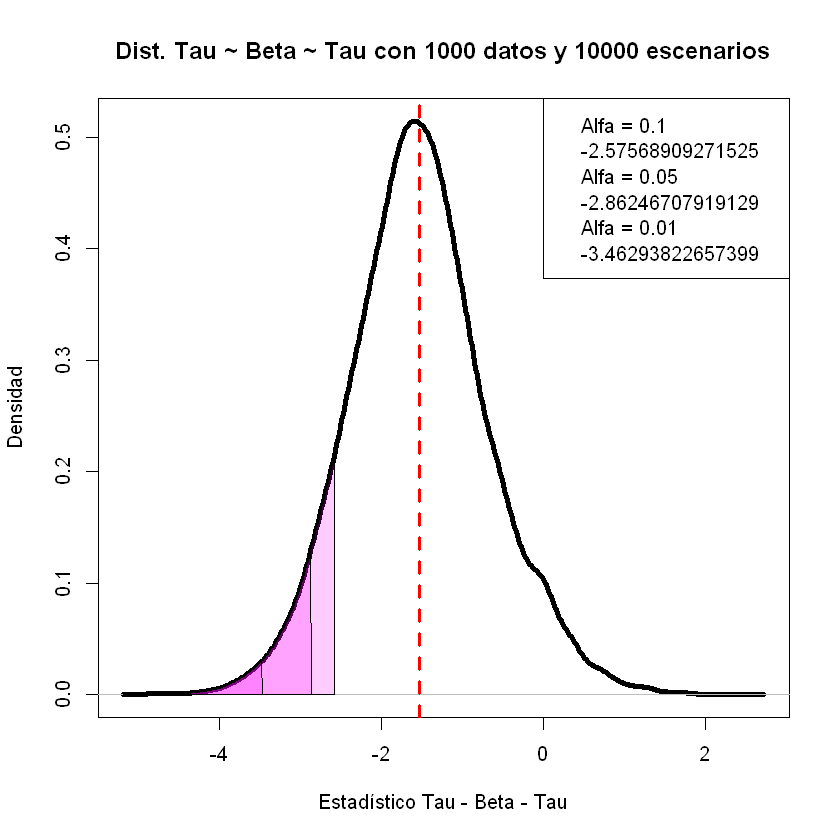

In [7]:
TauBT_G = function(T, S, Z_0 = 0, Sigma_a = 1, Plot = FALSE){  
  Zt <- c(Z_0)                                                    #Creando matriz con el valor inicial

  #Creando una matriz vacía para almacenar los estadísticos
  Tau_T = c()

  for (n in 1 : S){
    #Generando los errores
    set.seed(n)
    At <- rnorm(n = T ,mean = 0, sd = Sigma_a)

    #Corriendo la función generadora del PGD
    for(t in 2 : T){
      Zt[t] = Zt[t - 1] + At[t]
    }

    #Calculando la serie diferenciada
    Diferencia = function(Data){                                 # Operador de diferencia
        Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
        for(i in 1 : (T - 1)){
            Serie.dif[i] <- Data[i + 1] - Data[i]
        }
        return(Serie.dif)
    }
    X.Diff = Diferencia(Data = Zt)

    #Calculando la serie rezagada
    X.Rez <- Zt[1 : (T - 1)]
    
    #Estimando la regresión (OLS)
    Y = X.Diff
    X = cbind(1, X.Rez)
    Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)
    Gamma = Coeff[2]                                               # Coeficiente Gamma estimado

    # Estimación sigma^2 (Beta moño de OLS)
    Ym = X %*% Coeff
    Em = Y - Ym
    Sigma2 = as.numeric((t(Em) %*% Em) / (T - 2))
    Var.cov = (Sigma2 * solve(t(X) %*% X))
    Gamma_std = sqrt(Var.cov[2, 2])
    
    #Llenando la matriz
    Tau_T[n] <- Gamma / Gamma_std
  }

  # Quantiles
  Q_TT = matrix(data = c(quantile(Tau_T, probs = 0.1), quantile(Tau_T, probs = 0.05), quantile(Tau_T, probs = 0.01)), ncol = 3, nrow = 1)
  colnames(Q_TT) = c('10%', '5%', '1%')
  value2 = Q_TT[, 1]
  value3 = Q_TT[, 2]
  value4 = Q_TT[, 3]

  # Salidas
  if (Plot == FALSE){
    print(Q_TT)
  } else {
    Den = density(Tau_T)
    plot(Den, main = sprintf('Dist. Tau ~ Beta ~ Tau con %s datos y %s escenarios', T, S), xlab = "Estadístico Tau - Beta - Tau", ylab = "Densidad", col = "black", lty = 1, lwd = 4)
    legend(x= "topright" , legend = c("Alfa = 0.1", Q_TT[, 1], "Alfa = 0.05", Q_TT[, 2], "Alfa = 0.01", Q_TT[, 3]))
    polygon(c(Den$x[Den$x <= value2], value2),
        c(Den$y[Den$x <= value2], 0),
        col = rgb(1, 0, 1, alpha = 0.2),
        border = 1)
    polygon(c(Den$x[Den$x <= value3], value3),
      c(Den$y[Den$x <= value3], 0),
      col = rgb(1, 0, 1, alpha = 0.2),
      border = 1)
    polygon(c(Den$x[Den$x <= value4], value4),
        c(Den$y[Den$x <= value4], 0),
        col = rgb(1, 0, 1, alpha = 0.2),
        border = 1)
    abline(v = mean(Tau_T), col = "red", lwd = 3, lty = 2)
  }
}

TauBT_G(T = 1000, S = 10000, Plot = TRUE)

#### Phi_1

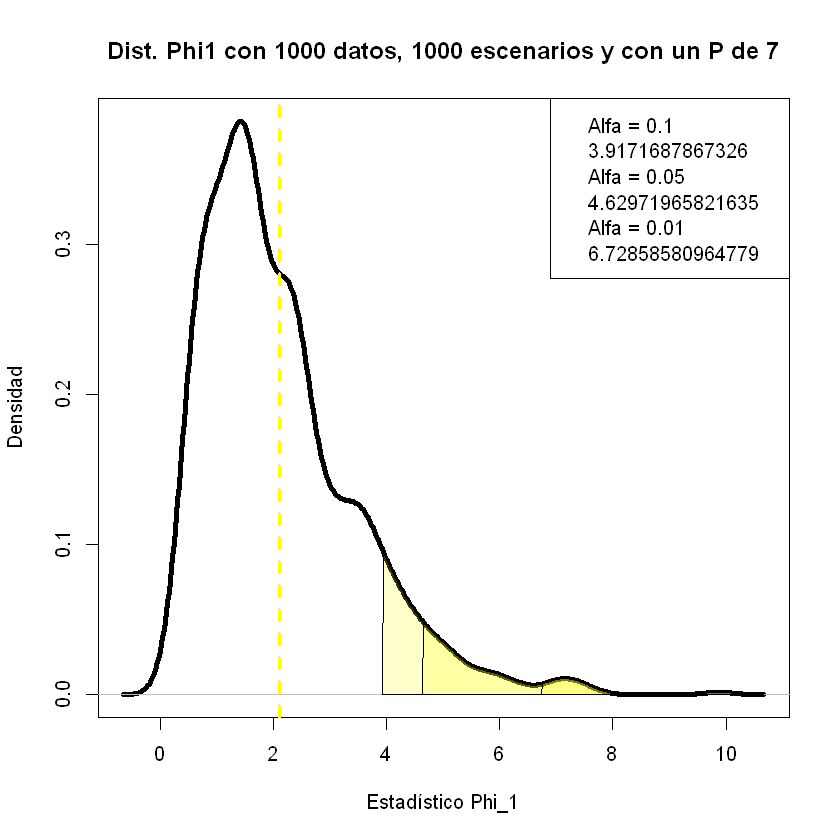

In [8]:
Phi1_G = function(T, S, P, Plot = FALSE, Z_0 = 0, Sigma_a = 1){  
  Zt <- c(Z_0)                                                    #Creando matriz con el valor inicial

  #Creando una matriz vacía para almacenar los estadísticos
  Phi_1 = matrix(data = NA, nrow = S, ncol = 1)

  for (n in 1 : S){    
    #Generando los errores
    set.seed(n)
    At <- rnorm(n = T ,mean = 0, sd = Sigma_a)

    #Corriendo la función generadora del PGD
    for(t in 2 : T){
      Zt[t] = Zt[t - 1] + At[t]
    }

    #Calculando la serie diferenciada
    Diferencia = function(Data){                                 # Operador de diferencia
        Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
        for(i in 1 : (T - 1)){
            Serie.dif[i] <- Data[i + 1] - Data[i]
        }
        return(Serie.dif)
    }
    X.Diff = Diferencia(Data = Zt)

    #Calculando la serie rezagada
    X.Rez <- Zt[2 : T]
    
    # Matriz delta
    Delta_P = matrix(data = NA, nrow = (T - 1), ncol = (P - 1))
    for(i in 1 : (T - 1)){
        for(j in 2 : P){
          X.d.r = X.Diff[(T - (T - j)) : T]
          Delta_P[i, (j - 1)] = X.d.r[i]
        }
    }
    Delta_P = Delta_P[-((T - P + 1) : T), ]
    
    #Estimando la regresión (OLS) modelo no restringido
    Y = X.Diff[1 : (T - P)]
    X = cbind(1, X.Rez[1 : (T - P)], Delta_P)
    Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)

    # Estimación SRC_nr
    Ym = X %*% Coeff
    Em = Y - Ym
    SRC_nr = as.numeric((t(Em) %*% Em))

    #Estimando la regresión (OLS) modelo restringido
    Y = X.Diff[1 : (T - P)]
    X = cbind(Delta_P)
    Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)

    # Estimación SRC_nr
    Ym = X %*% Coeff
    Em = Y - Ym
    SRC_r = as.numeric((t(Em) %*% Em))
    
    # #Llenando la matriz
    Phi_1[n] = ((SRC_r -  SRC_nr) / (2)) / ((SRC_nr) / (T - 2 - (P - 1))) 

  }

  # Quantiles
  Q_P1 = matrix(data = c(quantile(Phi_1, probs = 0.9), quantile(Phi_1, probs = 0.95), quantile(Phi_1, probs = 0.99)), ncol = 3, nrow = 1)
  colnames(Q_P1) = c('90%', '95%', '99%')

  # Salidas
  if (Plot == FALSE){
    print(Q_P1)
  } else {
    # Gráficas
    Den = density(Phi_1)
    value2 = Q_P1[, 1]
    value3 = Q_P1[, 2]
    value4 = Q_P1[, 3]
    plot(Den, main = sprintf('Dist. Phi1 con %s datos, %s escenarios y con un P de %s', T, S, P), xlab = "Estadístico Phi_1", ylab = "Densidad", col = "black", lty = 1, lwd = 4)
    legend(x= "topright" , legend = c("Alfa = 0.1", Q_P1[, 1], "Alfa = 0.05", Q_P1[, 2], "Alfa = 0.01", Q_P1[, 3]))
    polygon(c(Den$x[Den$x >= value2], value2),
        c(Den$y[Den$x >= value2], 0),
        col = rgb(1, 1, 0, alpha = 0.2),
        border = 1)
    polygon(c(Den$x[Den$x >= value3], value3),
      c(Den$y[Den$x >= value3], 0),
      col = rgb(1, 1, 0, alpha = 0.2),
      border = 1)
    polygon(c(Den$x[Den$x >= value4], value4),
        c(Den$y[Den$x >= value4], 0),
        col = rgb(1, 1, 0, alpha = 0.2),
        border = 1)
    abline(v = mean(Phi_1), col = rgb(1, 1, 0), lwd = 3, lty = 2)
  }
}

Phi1_G(T = 1000, S = 1000, P = 7, Plot = TRUE)

#### Phi_2

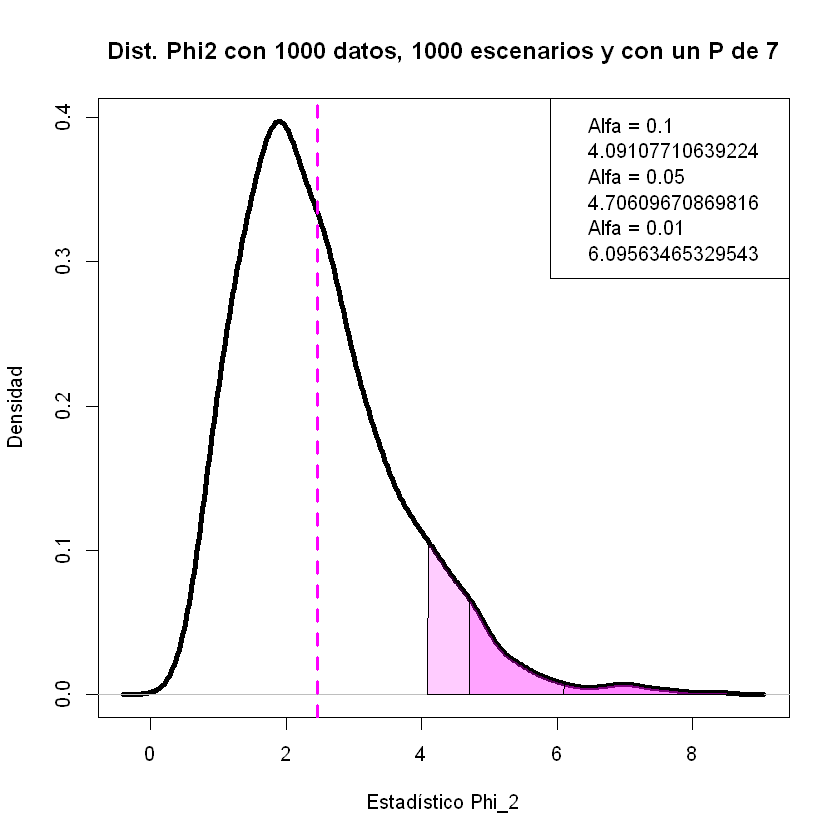

In [9]:
Phi2_G = function(T, S, P, Plot = FALSE, Z_0 = 0, Sigma_a = 1){  
  Zt <- c(Z_0)                                                    # Creando matriz con el valor inicial

  # Creando una matriz vacía para almacenar los estadísticos
  Phi_2 = matrix(data = NA, nrow = S, ncol = 1)

  for (n in 1 : S){    
    # Generando los errores
    set.seed(n)
    At <- rnorm(n = T ,mean = 0, sd = Sigma_a)

    # Corriendo la función generadora del PGD
    for(t in 2 : T){
      Zt[t] = Zt[t - 1] + At[t]
    }

    # Calculando la serie diferenciada
    Diferencia = function(Data){                                  # Operador de diferencia
        Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
        for(i in 1 : (T - 1)){
            Serie.dif[i] <- Data[i + 1] - Data[i]
        }
        return(Serie.dif)
    }
    X.Diff = Diferencia(Data = Zt)

    # Calculando la serie rezagada
    X.Rez <- Zt[2 : T]
    
    # Matriz delta
    Delta_P = matrix(data = NA, nrow = (T - 1), ncol = (P  - 1))
    for(i in 1 : (T - 1)){
        for(j in 2 : P){
          X.d.r = X.Diff[(T - (T - j)) : T]
          Delta_P[i, (j - 1)] = X.d.r[i]
        }
    }
    Delta_P = Delta_P[-((T - P + 1) : T), ]
    
    # Estimando la regresión (OLS) modelo no restringido
    Y = X.Diff[1 : (T - P)]
    X = cbind(1, c(1 : (T - P)), X.Rez[1 : (T - P)], Delta_P)
    Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)

    # Estimación SRC_nr
    Ym = X %*% Coeff
    Em = Y - Ym
    SRC_nr = as.numeric((t(Em) %*% Em))

    # Estimando la regresión (OLS) modelo restringido
    Y = X.Diff[1 : (T - P)]
    X = cbind(Delta_P)
    Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)

    # Estimación SRC_nr
    Ym = X %*% Coeff
    Em = Y - Ym
    SRC_r = as.numeric((t(Em) %*% Em))
    
    # Llenando la matriz
    Phi_2[n] = ((SRC_r -  SRC_nr) / (3)) / ((SRC_nr) / (T - 3 - (P - 1))) 

  }

  # Quantiles
  Q_P2 = matrix(data = c(quantile(Phi_2, probs = 0.9), quantile(Phi_2, probs = 0.95), quantile(Phi_2, probs = 0.99)), ncol = 3, nrow = 1)
  colnames(Q_P2) = c('90%', '95%', '99%')

  # Salidas
  if (Plot == FALSE){
    print(Q_P2)
  } else {
    # Gráficas
    Den = density(Phi_2)
    value2 = Q_P2[, 1]
    value3 = Q_P2[, 2]
    value4 = Q_P2[, 3]
    plot(Den, main = sprintf('Dist. Phi2 con %s datos, %s escenarios y con un P de %s', T, S, P), xlab = "Estadístico Phi_2", ylab = "Densidad", col = "black", lty = 1, lwd = 4)
    legend(x= "topright" , legend = c("Alfa = 0.1", Q_P2[, 1], "Alfa = 0.05", Q_P2[, 2], "Alfa = 0.01", Q_P2[, 3]))
    polygon(c(Den$x[Den$x >= value2], value2),
        c(Den$y[Den$x >= value2], 0),
        col = rgb(1, 0, 1, alpha = 0.2),
        border = 1)
    polygon(c(Den$x[Den$x >= value3], value3),
      c(Den$y[Den$x >= value3], 0),
      col = rgb(1, 0, 1, alpha = 0.2),
      border = 1)
    polygon(c(Den$x[Den$x >= value4], value4),
        c(Den$y[Den$x >= value4], 0),
        col = rgb(1, 0, 1, alpha = 0.2),
        border = 1)
    abline(v = mean(Phi_2), col = rgb(1, 0, 1), lwd = 3, lty = 2)
  }
}

Phi2_G(T = 1000, S = 1000, P = 7, Plot = TRUE)

#### Phi_3

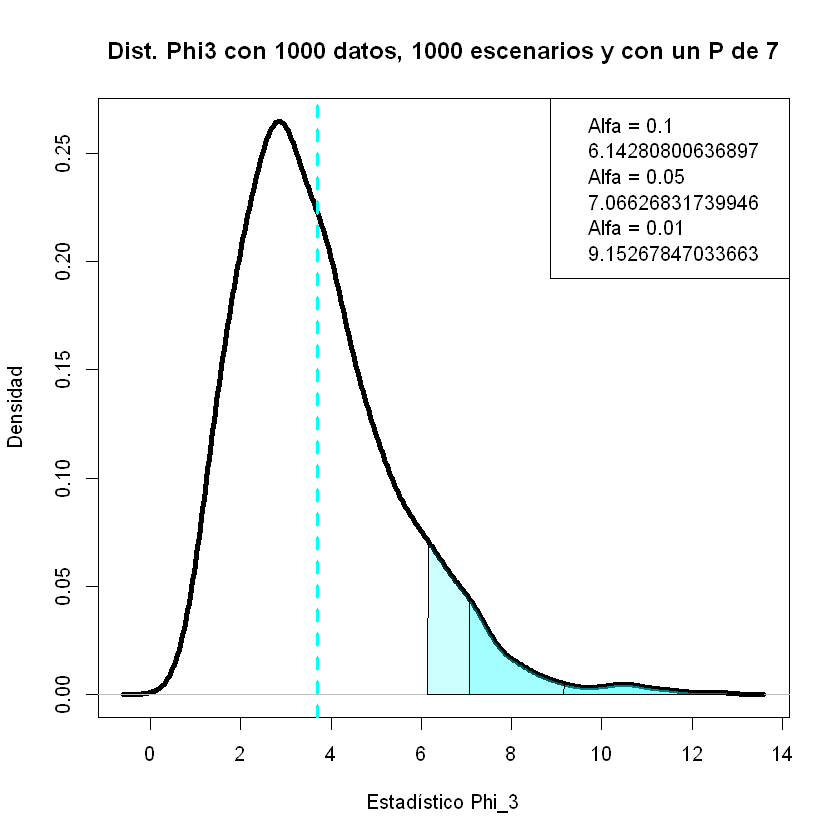

In [11]:
Phi3_G = function(T, S, P, Plot = FALSE, Z_0 = 0, Sigma_a = 1){    
  Zt <- c(Z_0)                                                    #Creando matriz con el valor inicial

  #Creando una matriz vacía para almacenar los estadísticos
  Phi_3 = matrix(data = NA, nrow = S, ncol = 1)

  for (n in 1 : S){    
    #Generando los errores
    set.seed(n)
    At <- rnorm(n = T ,mean = 0, sd = Sigma_a)

    #Corriendo la función generadora del PGD
    for(t in 2 : T){
      Zt[t] = Zt[t - 1] + At[t]
    }

    #Calculando la serie diferenciada
    Diferencia = function(Data){                                 # Operador de diferencia
        Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
        for(i in 1 : (T - 1)){
            Serie.dif[i] <- Data[i + 1] - Data[i]
        }
        return(Serie.dif)
    }
    X.Diff = Diferencia(Data = Zt)

    #Calculando la serie rezagada
    X.Rez <- Zt[2 : T]
    
    # Matriz delta
    Delta_P = matrix(data = NA, nrow = (T - 1), ncol = (P  - 1))
    for(i in 1 : (T - 1)){
        for(j in 2 : P){
          X.d.r = X.Diff[(T - (T - j)) : T]
          Delta_P[i, (j - 1)] = X.d.r[i]
        }
    }
    Delta_P = Delta_P[-((T - P + 1) : T), ]
    
    #Estimando la regresión (OLS) modelo no restringido
    Y = X.Diff[1 : (T - P)]
    X = cbind(1, c(1 : (T - P)), X.Rez[1 : (T - P)], Delta_P)
    Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)

    # Estimación SRC_nr
    Ym = X %*% Coeff
    Em = Y - Ym
    SRC_nr = as.numeric((t(Em) %*% Em))

    #Estimando la regresión (OLS) modelo restringido
    Y = X.Diff[1 : (T - P)]
    X = cbind(Delta_P)
    Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)

    # Estimación SRC_nr
    Ym = X %*% Coeff
    Em = Y - Ym
    SRC_r = as.numeric((t(Em) %*% Em))
    
    # Llenando la matriz
    Phi_3[n] = ((SRC_r -  SRC_nr) / (2)) / ((SRC_nr) / (T - 2 - (P - 1))) 

  }

  # Quantiles
  Q_P3 = matrix(data = c(quantile(Phi_3, probs = 0.9), quantile(Phi_3, probs = 0.95), quantile(Phi_3, probs = 0.99)), ncol = 3, nrow = 1)
  colnames(Q_P3) = c('90%', '95%', '99%')

  # Salidas
  if (Plot == FALSE){
    print(Q_P3)
  } else {
    # Gráficas
    Den = density(Phi_3)
    value2 = Q_P3[, 1]
    value3 = Q_P3[, 2]
    value4 = Q_P3[, 3]
    plot(Den, main = sprintf('Dist. Phi3 con %s datos, %s escenarios y con un P de %s', T, S, P), xlab = "Estadístico Phi_3", ylab = "Densidad", col = "black", lty = 1, lwd = 4)
    legend(x= "topright" , legend = c("Alfa = 0.1", Q_P3[, 1], "Alfa = 0.05", Q_P3[, 2], "Alfa = 0.01", Q_P3[, 3]))
    polygon(c(Den$x[Den$x >= value2], value2),
        c(Den$y[Den$x >= value2], 0),
        col = rgb(0, 1, 1, alpha = 0.2),
        border = 1)
    polygon(c(Den$x[Den$x >= value3], value3),
      c(Den$y[Den$x >= value3], 0),
      col = rgb(0, 1, 1, alpha = 0.2),
      border = 1)
    polygon(c(Den$x[Den$x >= value4], value4),
        c(Den$y[Den$x >= value4], 0),
        col = rgb(0, 1, 1, alpha = 0.2),
        border = 1)
    abline(v = mean(Phi_3), col = rgb(0, 1, 1), lwd = 3, lty = 2)
  }
}

Phi3_G(T = 1000, S = 1000, P = 7, Plot = TRUE)

### Dickey Fuller - Aumentado
**Parsimonio:**
- Cuando no halla suficiente evidencia para rechazar que todos los ordenes P son significativos en el modelo con un alpha de x% se denotará en la columna como un 1.
- Cuando halla suficiente evidencia para rechazar que todos los ordenes P son significativos en el modelo con un alpha de x% se denotará en la columna como un 0.

**Ljung - Box:**
- Cuando no halla suficiente evidencia para rechazar independencia en los errores con un alpha de x% se denotará en la columna como un 1.
- Cuando halla suficiente evidencia para rechazar independencia en los errores con un alpha de x% se denotará en la columna como un 0.

**Determinación del P óptimo:**

In [12]:
P_opt = function(Data, alpha = 0.05, Spam = 12){
    T = length(Data)

    # Función de rezago
    Rezago = function(Data, Rezago ){
        Rezago = Data[1 : (T - Rezago)]
        return(Rezago)
    }
    X.Res = Rezago(Data = Data, Rezago = 1)

    # Función de diferencia
    Diferencia = function(Data){
        Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
        for(i in 1: (T - 1)){
            Serie.dif[i] <- Data[i + 1] - Data[i]
        }
        return(Serie.dif)
    }
    X.Diff = Diferencia(Data)

    # Función de Parsimonio
    Parsimonio = function(Delta, Delta.var){
        Desv = sqrt(Delta.var)
        Vec = Delta
        for (i in 1 : length(Delta)){
            LS = Delta[i] + (2 * Desv[i])
            LI = Delta[i] - (2 * Desv[i])
            if (LS > 0 & LI > 0 || LS < 0 & LI < 0){
                Vec[i] = 1
            } else {
                Vec[i] = 0
            }
        }
        Vec = data.frame(Vec)
        colnames(Vec) = c('Test de parsimonia')
        return(Sum_vec = sum(Vec))
        # print(Vec)
        # print(Sum_vec)
    }

    # Función de Ljung - Box
    L.B = function(At, K, AR_P){
        t = AR_P + 1
        T = length(At)    
        Rho_at = matrix(data = NA, nrow = (T - K), ncol = 1)
        for (i in 1 : (T - K)){
            Rho_at[i] = sum(At[i] * At[(i + t)]) / sum(At ** 2)
        }

        # Prueba de Ljung - Box
        Q = (T - AR_P) * (T - AR_P + 2) * (sum((sum(Rho_at) ** 2) / (T - AR_P - K))) 
        Vc = qchisq(p = alpha, df = (T - AR_P))

        # Salida
        if (Q < Vc){
            1
        } else {
            0
        } 
    }

    # Creación de la matriz P óptimo
    P.I = Spam * 4                                                                            # ¿Cambiar a T / 4?
    P_est = matrix(data = NA, nrow = (P.I - 1), ncol = 4)
    colnames(P_est) = c('P', 'Lj-Bx', 'Parsimonia', 'Check')
    P_est[, 1] = c(P.I : 2)

    for (p in 1 : (P.I - 1)){                                                              # Obtención del P adecuado
        P = P_est[p, 1]
       
        # Matriz delta
        Delta_P = matrix(data = NA, nrow = (T - 1), ncol = (P - 1))
        for(i in 1 : (T - 1)){
            for(j in 2 : P){
                X.d.r = X.Diff[(T - (T - j)) : T]
                Delta_P[i, (j - 1)] = X.d.r[i]
            }
        }
        Delta_P = Delta_P[-((T - P + 1) : T), ]

        # Simulación de cada escenario para cada P
        Y = cbind(X.Diff[1 : (T - P)])
        X = cbind(1, (1 : (T - P)), X.Res[1 : (T - P)], Delta_P)
        Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)

        Ym = X %*% Coeff
        Em = Y - Ym
        
        Sigma2 = as.numeric((t(Em) %*% Em) / (T - 3))
        Var.cov = (Sigma2 * solve(t(X) %*% X))
        Beta = Coeff[P + 2]
        Var.Beta = Var.cov[(P + 2), (P + 2)]
        P_est = data.frame(P_est)
        
        # Pruebas para obtener el P óptimo
        P_est[p, 2] = L.B(At = Em, K = length(Coeff), AR_P = P)
        P_est[p, 3] = Parsimonio(Delta = Beta, Delta.var = Var.Beta)
        Check = P_est[p, 2] + P_est[p, 3]
        if (Check == 2){
            P_est[p, 4] = 'P. necesario'
            break
        } else {
            P_est[p, 4] = 'P. innecesario'
        }
    }

    # P óptimo
    P = P

    # Salidas
    print(P_est[(1 : (P.I - P + 1)), ])
    return(sprintf('El parámetro P necesario para hacer la prueba es P = %s.', P))   
}

P_opt(Data = X.data, alpha = 0.05, Spam = 12)

    P Lj.Bx Parsimonia          Check
1  48     1          0 P. innecesario
2  47     1          0 P. innecesario
3  46     1          0 P. innecesario
4  45     1          0 P. innecesario
5  44     1          0 P. innecesario
6  43     1          0 P. innecesario
7  42     1          0 P. innecesario
8  41     1          0 P. innecesario
9  40     1          0 P. innecesario
10 39     1          0 P. innecesario
11 38     1          1   P. necesario


[1] "El parámetro P necesario para hacer la prueba es P = 38."

**Prueba Tau ~ Tau:**
$$
\tau_{\tau} \rightarrow \Delta{y_t} = \alpha + \beta t + \gamma y_{t - 1} + \sum^{P}_{i = 2}{\beta_{i}\Delta y_{t - i + 1}} + \epsilon_{t}
$$

**Prueba Phi ~ 3:**
$$
\phi_3 \rightarrow \Delta{y_t} = \alpha + \sum^{P}_{i = 2}{\beta_{i}\Delta y_{t - i + 1}} + \epsilon_{t}
$$

**Prueba Auxiliar:**
$$
Aux \rightarrow \Delta{y_t} = \alpha + \beta t + \sum^{P}_{i = 2}{\beta_{i}\Delta y_{t - i + 1}} + \epsilon_{t}
$$

In [25]:
ATau.T = function(Data, P, alpha = 0.05){
    # Datos usados
    T = length(Data)
    
    # Simulación dsitribución Tau ~ Tau
    TauT_G = function(T, S, Z_0 = 0, Sigma_a = 1, Plot = FALSE){
        Zt <- c(Z_0)                                                    #Creando matriz con el valor inicial

        #Creando una matriz vacía para almacenar los estadísticos
        Tau_T = c()

        for (n in 1 : S){
            #Generando los errores
            set.seed(n)
            At <- rnorm(n = T ,mean = 0, sd = Sigma_a)

            #Corriendo la función generadora del PGD
            for(t in 2 : T){
            Zt[t] = Zt[t - 1] + At[t]
            }

            #Calculando la serie diferenciada
            Diferencia = function(Data){                                 # Operador de diferencia
                Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
                for(i in 1 : (T - 1)){
                    Serie.dif[i] <- Data[i + 1] - Data[i]
                }
                return(Serie.dif)
            }
            X.Diff = Diferencia(Data = Zt)

            #Calculando la serie rezagada
            X.Rez <- Zt[1 : (T - 1)]
            
            #Estimando la regresión (OLS)
            Y = X.Diff
            X = cbind(1, c(1 : (T - 1)), X.Rez)
            Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)
            Gamma = Coeff[3]                                               # Coeficiente Gamma estimado

            # Estimación sigma^2 (Beta moño de OLS)
            Ym = X %*% Coeff
            Em = Y - Ym
            Sigma2 = as.numeric((t(Em) %*% Em) / (T - 3))
            Var.cov = (Sigma2 * solve(t(X) %*% X))
            Gamma_std = sqrt(Var.cov[3, 3])
            
            #Llenando la matriz
            Tau_T[n] <- Gamma / Gamma_std
        }

        # Quantiles
        Q_TT = matrix(data = c(quantile(Tau_T, probs = 0.1), quantile(Tau_T, probs = 0.05), quantile(Tau_T, probs = 0.01)), ncol = 3, nrow = 1)
        colnames(Q_TT) = c('10%', '5%', '1%')
        value2 = Q_TT[, 1]
        value3 = Q_TT[, 2]
        value4 = Q_TT[, 3]

        # Salidas
        if (Plot == FALSE){
            Q_TT
        } else {
            Den = density(Tau_T)
            plot(Den, main = sprintf('Dist. Tau ~ T con %s datos y %s escenarios', T, S), xlab = "Estadístico Tau - Tau", ylab = "Densidad", col = "black", lty = 1, lwd = 4)
            legend(x= "topright" , legend = c("Alfa = 0.1", Q_TT[, 1], "Alfa = 0.05", Q_TT[, 2], "Alfa = 0.01", Q_TT[, 3]))
            polygon(c(Den$x[Den$x <= value2], value2),
                c(Den$y[Den$x <= value2], 0),
                col = rgb(1, 0, 0, alpha = 0.2),
                border = 1)
            polygon(c(Den$x[Den$x <= value3], value3),
            c(Den$y[Den$x <= value3], 0),
            col = rgb(1, 0, 0, alpha = 0.2),
            border = 1)
            polygon(c(Den$x[Den$x <= value4], value4),
                c(Den$y[Den$x <= value4], 0),
                col = rgb(1, 0, 0, alpha = 0.2),
                border = 1)
            abline(v = mean(Tau_T), col = "red", lwd = 3, lty = 2)
        }
    }

    # Simulación distribución Phi ~ 3
    Phi3_G = function(T, S, P, Plot = FALSE, Z_0 = 0, Sigma_a = 1){
        Zt <- c(Z_0)                                                    #Creando matriz con el valor inicial

        #Creando una matriz vacía para almacenar los estadísticos
        Phi_3 = matrix(data = NA, nrow = S, ncol = 1)

        for (n in 1 : S){    
            #Generando los errores
            set.seed(n)
            At <- rnorm(n = T ,mean = 0, sd = Sigma_a)

            #Corriendo la función generadora del PGD
            for(t in 2 : T){
            Zt[t] = Zt[t - 1] + At[t]
            }

            #Calculando la serie diferenciada
            Diferencia = function(Data){                                 # Operador de diferencia
                Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
                for(i in 1 : (T - 1)){
                    Serie.dif[i] <- Data[i + 1] - Data[i]
                }
                return(Serie.dif)
            }
            X.Diff = Diferencia(Data = Zt)

            #Calculando la serie rezagada
            X.Rez <- Zt[2 : T]
            
            # Matriz delta
            Delta_P = matrix(data = NA, nrow = (T - 1), ncol = (P  - 1))
            for(i in 1 : (T - 1)){
                for(j in 2 : P){
                X.d.r = X.Diff[(T - (T - j)) : T]
                Delta_P[i, (j - 1)] = X.d.r[i]
                }
            }
            Delta_P = Delta_P[-((T - P + 1) : T), ]
            
            #Estimando la regresión (OLS) modelo no restringido
            Y = X.Diff[1 : (T - P)]
            X = cbind(1, c(1 : (T - P)), X.Rez[1 : (T - P)], Delta_P)
            Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)

            # Estimación SRC_nr
            Ym = X %*% Coeff
            Em = Y - Ym
            SRC_nr = as.numeric((t(Em) %*% Em))

            #Estimando la regresión (OLS) modelo restringido
            Y = X.Diff[1 : (T - P)]
            X = cbind(Delta_P)
            Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)

            # Estimación SRC_r
            Ym = X %*% Coeff
            Em = Y - Ym
            SRC_r = as.numeric((t(Em) %*% Em))
            
            # #Llenando la matriz
            Phi_3[n] = ((SRC_r -  SRC_nr) / (2)) / ((SRC_nr) / (T - 2 - (P - 1))) 

        }

        # Quantiles
        Q_P3 = matrix(data = c(quantile(Phi_3, probs = 0.9), quantile(Phi_3, probs = 0.95), quantile(Phi_3, probs = 0.99)), ncol = 3, nrow = 1)
        colnames(Q_P3) = c('90%', '95%', '99%')

        # Salidas
        if (Plot == FALSE){
            Q_P3
        } else {
            # Gráficas
            Den = density(Phi_3)
            value2 = Q_P3[, 1]
            value3 = Q_P3[, 2]
            value4 = Q_P3[, 3]
            plot(Den, main = sprintf('Dist. Phi3 con %s datos, %s escenarios y con un P de %s', T, S, P), xlab = "Estadístico Phi_3", ylab = "Densidad", col = "black", lty = 1, lwd = 4)
            legend(x= "topright" , legend = c("Alfa = 0.1", Q_P3[, 1], "Alfa = 0.05", Q_P3[, 2], "Alfa = 0.01", Q_P3[, 3]))
            polygon(c(Den$x[Den$x >= value2], value2),
                c(Den$y[Den$x >= value2], 0),
                col = rgb(0, 1, 1, alpha = 0.2),
                border = 1)
            polygon(c(Den$x[Den$x >= value3], value3),
            c(Den$y[Den$x >= value3], 0),
            col = rgb(0, 1, 1, alpha = 0.2),
            border = 1)
            polygon(c(Den$x[Den$x >= value4], value4),
                c(Den$y[Den$x >= value4], 0),
                col = rgb(0, 1, 1, alpha = 0.2),
                border = 1)
            abline(v = mean(Phi_3), col = rgb(0, 1, 1), lwd = 3, lty = 2)
        }
    }

    # Función de rezago
    Rezago = function(Data, Rezago){
        Rezago = Data[1 : (T - Rezago)]
        return(Rezago)
    }
    X.Res = Rezago(Data = Data, Rezago = 1)

    # Función de diferencia
    Diferencia = function(Data){
    Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
        for(i in 1: (T - 1)){
            Serie.dif[i] <- Data[i + 1] - Data[i]
        }
        return(Serie.dif)
    }
    X.Diff = Diferencia(Data)

    # Matriz delta de orden P
    Delta_P = matrix(data = NA, nrow = (T - 1), ncol = (P - 1))
    for(i in 1 : (T - 1)){
        for(j in 2 : P){
        X.d.r = X.Diff[(T - (T - j)) : T]
        Delta_P[i, (j - 1)] = X.d.r[i]
        }
    }
    Delta_P = Delta_P[-((T - P + 1) : T), ]
    
    ############################################################################ Prueba Tau ~ Tau ############################################################################
    Y.M1 = cbind(X.Diff[1 : (T - P)])
    X.M1 = cbind(1, (1 : (T - P)), X.Res[1 : (T - P)], Delta_P)                             # X con los datos del modelo Tau ~ Tau

    Coeff.M1 = solve(t(X.M1) %*% X.M1) %*% (t(X.M1) %*% Y.M1)
    At.M1 = Y.M1 - (X.M1 %*% Coeff.M1)
    Sigma2.M1 = as.numeric((t(At.M1) %*% At.M1) / (T - (3 + P)))
    Varcov.M1 = Sigma2.M1 * solve(t(X.M1) %*% X.M1)

    # Prueba Tau ~ Tau
    Gamma.M1 = Coeff.M1[3]
    Var.Gamma.M1 = Varcov.M1[3, 3]

    # Estimación SRC_nr
    Ym.M1 = X.M1 %*% Coeff.M1
    Em.M1 = Y.M1 - Ym.M1                                                     
    SRC_nr = as.numeric((t(Em.M1) %*% Em.M1))

    ############################################################################# Prueba Phi ~ 3 #############################################################################
    Y.P3 = cbind(X.Diff[1 : (T - P)])
    X.P3 = cbind(1, Delta_P)                                            # X con los datos del modelo Phi ~ 3

    Coeff.P3 = solve(t(X.P3) %*% X.P3) %*% (t(X.P3) %*% Y.P3)
    At.P3 = Y.P3 - (X.P3 %*% Coeff.P3)
    Sigma2.P3 = as.numeric((t(At.P3) %*% At.P3) / (T - (1 + P)))
    Varcov.P3 = Sigma2.P3 * solve(t(X.P3) %*% X.P3)

    # Estimación SRC_r
    Ym.P3 = X.P3 %*% Coeff.P3
    Em.P3 = Y.P3 - Ym.P3
    SRC_r = as.numeric((t(Em.P3) %*% Em.P3))
    
    # Prubea Phi ~ 3
    Phi3 = ((SRC_r -  SRC_nr) / (2)) / ((SRC_nr) / (T - 3 - (P - 1))) 

    ############################################################################# Prueba Auxiliar ############################################################################
    Y.B = cbind(X.Diff[1 : (T - P)])
    X.B = cbind(1, (1 : (T - P)), Delta_P)                             # X con los datos del modelo Auxiliar (Beta)

    Coeff.B = solve(t(X.B) %*% X.B) %*% (t(X.B) %*% Y.B)
    At.B = Y.B - (X.B %*% Coeff.B)
    Sigma2.B = as.numeric((t(At.B) %*% At.B) / (T - (2 + P)))
    Varcov.B = Sigma2.B * solve(t(X.B) %*% X.B)

    # Prueba Auxiliar (Beta)
    Beta = Coeff.B[2]
    Var.Beta = Varcov.B[2, 2]
    
    ################################################################################ Salidas #################################################################################
    # Tabla de V.C
    TT = TauT_G(T = 1000, S = 10000, Plot = FALSE)
    P3 = Phi3_G(T = 1000, S = 700, P = 7, Plot = FALSE)
    Table = matrix(data = NA, nrow = 4, ncol = 4)
    rownames(Table) = c('Gamma', 'Phi3', 'Beta', 'Gammat')
    colnames(Table) = c('Stat.', 'alpha 0.05', 'alpha 0.01', 'Conclusión')
    Table[1, 1] = round(Gamma.M1 / sqrt(Var.Gamma.M1), 10)                          # Statistics
    Table[2, 1] = round(Phi3, 4)
    Table[3, 1] = round(Beta / sqrt(Var.Beta), 10)
    Table[4, 1] = round(Gamma.M1 / sqrt(Var.Gamma.M1), 10)
    Table[1, 2] = round(TT[, 2], 4)                                                 # Alpha Columna 1
    Table[1, 3] = round(TT[, 3], 4)
    Table[2, 2] = round(P3[, 2], 4)                                                 # Alpha Columna 2
    Table[2, 3] = round(P3[, 3], 4)
    Table[3, 2] = round(qt(p = 0.05, df = T - (2 + P), lower.tail = FALSE), 4)      # Alpha Columna 3
    Table[3, 3] = round(qt(p = 0.01, df = T - (2 + P), lower.tail = FALSE), 4)
    Table[4, 2] = round(qt(p = 0.05, df = T - (3 + P), lower.tail = TRUE), 4)       # Alpha Columna 4
    Table[4, 3] = round(qt(p = 0.01, df = T - (3 + P), lower.tail = TRUE), 4)

    Table = data.frame(Table)

    if (alpha == 0.05){
        if (Table[1, 1] < Table[1, 2]){
            Table[1, 4] = sprintf('No hay raíz unitaria con un alpha del %s', alpha)
            Table.1 = Table[1, ]
            return(Table.1)
        }
        if (Table[1, 1] > Table[1, 2]){
            Table[1, 4] = sprintf('Hay raíz unitaria con un alpha del %s', alpha)
        }
        if (Table[2, 1] < Table[2, 2]){                                    
            Table[2, 4] = sprintf('Phi ~ 3 no es significativo con un alpha del %s', alpha)
            Table.2 = Table[1 : 2, ]
            return(Table.2)
        }
        if (Table[2, 1] > Table[2, 2]){                                         
            Table[2, 4] = sprintf('Phi ~ 3 es significativo con un alpha del %s', alpha)
        }
        if (Table[3, 1] < Table[3, 2]){
            Table[3, 4] = sprintf('Beta (Tendencia) no es significativo con un alpha del %s', alpha)
            Table.3 = Table[1 : 3, ]
            return(Table.3)
        }
        if (Table[3, 1] > Table[3, 2]){
            Table[3, 4] = sprintf('Beta (Tendencia) es significativo con un alpha del %s', alpha)
        }
        if (Table[4, 1] < Table[4, 2]){
            Table[4, 4] = sprintf('(Gamma ~ t) No hay raíz unitaria con un alpha del %s', alpha)
            return(Table)
        }
        if (Table[4, 1] > Table[4, 2]){
            Table[4, 4] = sprintf('(Gamma ~ t) Hay raíz unitaria con un alpha del %s', alpha)
            return(Table)
        }
    }
    if (alpha == 0.01){
        if (Table[1, 1] < Table[1, 3]){
            Table[1, 4] = sprintf('No hay raíz unitaria con un alpha del %s', alpha)
            Table.1 = Table[1, ]
            return(Table.1)
        }
        if (Table[1, 1] > Table[1, 3]){
            Table[1, 4] = sprintf('Hay raíz unitaria con un alpha del %s', alpha)
        }
        if (Table[2, 1] < Table[2, 3]){                                    
            Table[2, 4] = sprintf('Phi ~ 3 no es significativo con un alpha del %s', alpha)
            Table.2 = Table[1 : 2, ]
            return(Table.2)
        }
        if (Table[2, 1] > Table[2, 3]){                                         
            Table[2, 4] = sprintf('Phi ~ 3 es significativo con un alpha del %s', alpha)
        }
        if (Table[3, 1] < Table[3, 3]){
            Table[3, 4] = sprintf('Beta (Tendencia) no es significativo con un alpha del %s', alpha)
            Table.3 = Table[1 : 3, ]
            return(Table.3)
        }
        if (Table[3, 1] > Table[3, 3]){
            Table[3, 4] = sprintf('Beta (Tendencia) es significativo con un alpha del %s', alpha)
        }
        if (Table[4, 1] < Table[4, 3]){
            Table[4, 4] = sprintf('(Gamma ~ t) No hay raíz unitaria con un alpha del %s', alpha)
            return(Table)
        }
        if (Table[4, 1] > Table[4, 3]){
            Table[4, 4] = sprintf('(Gamma ~ t) Hay raíz unitaria con un alpha del %s', alpha)
            return(Table)
        }
    }
}

ATau.T(Data = X.data, P = 38, alpha = 0.05)

,Stat.,alpha.0.05,alpha.0.01,Conclusión
,<dbl>,<dbl>,<dbl>,<chr>
Gamma,-1.734752,-3.404,-3.9316,Hay raíz unitaria con un alpha del 0.05
Phi3,3.989400,7.120,9.2331,Phi ~ 3 no es significativo con un alpha del 0.05


**Prueba Tau ~ Mu:**
$$
\Delta{y_t} = \alpha + \gamma y_{t - 1} + \sum^{P}_{i = 2}{\beta_{i}\Delta y_{t - i + 1}} + \epsilon_{t}
$$

**Prueba Phi ~ 1:**
$$
\phi_1 \rightarrow \Delta{y_t} = \sum^{P}_{i = 2}{\beta_{i}\Delta y_{t - i + 1}} + \epsilon_{t}
$$

**Prueba Auxiliar:**
$$
Aux \rightarrow \Delta{y_t} = \alpha + \sum^{P}_{i = 2}{\beta_{i}\Delta y_{t - i + 1}} + \epsilon_{t}
$$

In [28]:
ATau.M = function(Data, P, alpha = 0.05){
    # Datos usados
    T = length(Data)
    
    # Simulación dsitribución Tau ~ Mu
    TauM_G = function(T, S, Z_0 = 0, Sigma_a = 1, Plot = FALSE){  
        Zt <- c(Z_0)                                                    #Creando matriz con el valor inicial

        #Creando una matriz vacía para almacenar los estadísticos
        Tau_M = c()

        for (n in 1 : S){
            #Generando los errores
            set.seed(n)
            At <- rnorm(n = T ,mean = 0, sd = Sigma_a)

            #Corriendo la función generadora del PGD
            for(t in 2 : T){
            Zt[t] = Zt[t - 1] + At[t]
            }

            #Calculando la serie diferenciada
            Diferencia = function(Data){                                 # Operador de diferencia
                Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
                for(i in 1 : (T - 1)){
                    Serie.dif[i] <- Data[i + 1] - Data[i]
                }
                return(Serie.dif)
            }
            X.Diff = Diferencia(Data = Zt)

            #Calculando la serie rezagada
            X.Rez <- Zt[1 : (T - 1)]
            
            #Estimando la regresión (OLS)
            Y = X.Diff
            X = cbind(1, X.Rez)
            Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)
            Gamma = Coeff[2]                                               # Coeficiente Gamma estimado

            # Estimación sigma^2 (Beta moño de OLS)
            Ym = X %*% Coeff
            Em = Y - Ym
            Sigma2 = as.numeric((t(Em) %*% Em) / (T - 2))
            Var.cov = (Sigma2 * solve(t(X) %*% X))
            Gamma_std = sqrt(Var.cov[2, 2])
            
            #Llenando la matriz
            Tau_M[n] <- Gamma / Gamma_std
        }
        # Quantiles
        Q_TM = matrix(data = c(quantile(Tau_M, probs = 0.1), quantile(Tau_M, probs = 0.05), quantile(Tau_M, probs = 0.01)), ncol = 3, nrow = 1)
        colnames(Q_TM) = c('10%', '5%', '1%')
        value2 = Q_TM[, 1]
        value3 = Q_TM[, 2]
        value4 = Q_TM[, 3]

        # Salidas 
        if (Plot == FALSE){
            Q_TM
        } else {
            
            # Gráficas
            Den = density(Tau_M)
            plot(Den, main = sprintf('Dist. Tau ~ Mu con %s datos y %s escenarios', T, S), xlab="Estadístico Tau - Mu", ylab="Densidad", col="black", lty=1, lwd=4)
            legend(x= "topright" , legend = c("Alfa = 0.1", Q_TM[, 1], "Alfa = 0.05", Q_TM[, 2], "Alfa = 0.01", Q_TM[, 3]))
            polygon(c(Den$x[Den$x <= value2], value2),
                c(Den$y[Den$x <= value2], 0),
                col = rgb(0, 0, 1, alpha = 0.2),
                border = 1)
            polygon(c(Den$x[Den$x <= value3], value3),
            c(Den$y[Den$x <= value3], 0),
            col = rgb(0, 0, 1, alpha = 0.2),
            border = 1)
            polygon(c(Den$x[Den$x <= value4], value4),
                c(Den$y[Den$x <= value4], 0),
                col = rgb(0, 0, 1, alpha = 0.2),
                border = 1)
            abline(v = mean(Tau_M), col = "blue", lwd = 3, lty = 2)
        }
    }

    # Simulación distribución Phi ~ 1
    Phi1_G = function(T, S, P, Plot = FALSE, Z_0 = 0, Sigma_a = 1){  
        Zt <- c(Z_0)                                                    #Creando matriz con el valor inicial

        #Creando una matriz vacía para almacenar los estadísticos
        Phi_1 = matrix(data = NA, nrow = S, ncol = 1)

        for (n in 1 : S){    
            #Generando los errores
            set.seed(n)
            At <- rnorm(n = T ,mean = 0, sd = Sigma_a)

            #Corriendo la función generadora del PGD
            for(t in 2 : T){
            Zt[t] = Zt[t - 1] + At[t]
            }

            #Calculando la serie diferenciada
            Diferencia = function(Data){                                 # Operador de diferencia
                Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
                for(i in 1 : (T - 1)){
                    Serie.dif[i] <- Data[i + 1] - Data[i]
                }
                return(Serie.dif)
            }
            X.Diff = Diferencia(Data = Zt)

            #Calculando la serie rezagada
            X.Rez <- Zt[2 : T]
            
            # Matriz delta
            Delta_P = matrix(data = NA, nrow = (T - 1), ncol = (P - 1))
            for(i in 1 : (T - 1)){
                for(j in 2 : P){
                X.d.r = X.Diff[(T - (T - j)) : T]
                Delta_P[i, (j - 1)] = X.d.r[i]
                }
            }
            Delta_P = Delta_P[-((T - P + 1) : T), ]
            
            #Estimando la regresión (OLS) modelo no restringido
            Y = X.Diff[1 : (T - P)]
            X = cbind(1, X.Rez[1 : (T - P)], Delta_P)
            Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)

            # Estimación SRC_nr
            Ym = X %*% Coeff
            Em = Y - Ym
            SRC_nr = as.numeric((t(Em) %*% Em))

            #Estimando la regresión (OLS) modelo restringido
            Y = X.Diff[1 : (T - P)]
            X = cbind(Delta_P)
            Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)

            # Estimación SRC_nr
            Ym = X %*% Coeff
            Em = Y - Ym
            SRC_r = as.numeric((t(Em) %*% Em))
            
            # #Llenando la matriz
            Phi_1[n] = ((SRC_r -  SRC_nr) / (2)) / ((SRC_nr) / (T - 2 - (P - 1))) 

        }

        # Quantiles
        Q_P1 = matrix(data = c(quantile(Phi_1, probs = 0.9), quantile(Phi_1, probs = 0.95), quantile(Phi_1, probs = 0.99)), ncol = 3, nrow = 1)
        colnames(Q_P1) = c('90%', '95%', '99%')

        # Salidas
        if (Plot == FALSE){
            Q_P1
        } else {
            # Gráficas
            Den = density(Phi_1)
            value2 = Q_P1[, 1]
            value3 = Q_P1[, 2]
            value4 = Q_P1[, 3]
            plot(Den, main = sprintf('Dist. Phi1 con %s datos, %s escenarios y con un P de %s', T, S, P), xlab = "Estadístico Phi_1", ylab = "Densidad", col = "black", lty = 1, lwd = 4)
            legend(x= "topright" , legend = c("Alfa = 0.1", Q_P1[, 1], "Alfa = 0.05", Q_P1[, 2], "Alfa = 0.01", Q_P1[, 3]))
            polygon(c(Den$x[Den$x >= value2], value2),
                c(Den$y[Den$x >= value2], 0),
                col = rgb(1, 1, 0, alpha = 0.2),
                border = 1)
            polygon(c(Den$x[Den$x >= value3], value3),
            c(Den$y[Den$x >= value3], 0),
            col = rgb(1, 1, 0, alpha = 0.2),
            border = 1)
            polygon(c(Den$x[Den$x >= value4], value4),
                c(Den$y[Den$x >= value4], 0),
                col = rgb(1, 1, 0, alpha = 0.2),
                border = 1)
            abline(v = mean(Phi_1), col = rgb(1, 1, 0), lwd = 3, lty = 2)
        }
    }

    # Función de rezago
    Rezago = function(Data, Rezago){
        Rezago = Data[1 : (T - Rezago)]
        return(Rezago)
    }
    X.Res = Rezago(Data = Data, Rezago = 1)

    # Función de diferencia
    Diferencia = function(Data){
    Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
        for(i in 1: (T - 1)){
            Serie.dif[i] <- Data[i + 1] - Data[i]
        }
        return(Serie.dif)
    }
    X.Diff = Diferencia(Data)

    # Matriz delta de orden P
    Delta_P = matrix(data = NA, nrow = (T - 1), ncol = (P - 1))
    for(i in 1 : (T - 1)){
        for(j in 2 : P){
        X.d.r = X.Diff[(T - (T - j)) : T]
        Delta_P[i, (j - 1)] = X.d.r[i]
        }
    }
    Delta_P = Delta_P[-((T - P + 1) : T), ]
    
    ############################################################################ Prueba Tau ~ Mu ############################################################################
    Y.M1 = cbind(X.Diff[1 : (T - P)])
    X.M1 = cbind(1, X.Res[1 : (T - P)], Delta_P)                             # X con los datos del modelo Tau ~ Mu

    Coeff.M1 = solve(t(X.M1) %*% X.M1) %*% (t(X.M1) %*% Y.M1)
    At.M1 = Y.M1 - (X.M1 %*% Coeff.M1)
    Sigma2.M1 = as.numeric((t(At.M1) %*% At.M1) / (T - (2 + P)))
    Varcov.M1 = Sigma2.M1 * solve(t(X.M1) %*% X.M1)

    # Prueba Tau ~ Mu
    Gamma.M1 = Coeff.M1[2]
    Var.Gamma.M1 = Varcov.M1[2, 2]

    # Estimación SRC_nr
    Ym.M1 = X.M1 %*% Coeff.M1
    Em.M1 = Y.M1 - Ym.M1
    SRC_nr = as.numeric((t(Em.M1) %*% Em.M1))

    ############################################################################# Prueba Phi ~ 1 #############################################################################
    Y.P1 = cbind(X.Diff[1 : (T - P)])
    X.P1 = cbind(Delta_P)                                            # X con los datos del modelo Phi ~ 1

    Coeff.P1 = solve(t(X.P1) %*% X.P1) %*% (t(X.P1) %*% Y.P1)
    At.P1 = Y.P1 - (X.P1 %*% Coeff.P1)
    Sigma2.P1 = as.numeric((t(At.P1) %*% At.P1) / (T - P))
    Varcov.P1 = Sigma2.P1 * solve(t(X.P1) %*% X.P1)

    # Estimación SRC_r
    Ym.P1 = X.P1 %*% Coeff.P1
    Em.P1 = Y.P1 - Ym.P1
    SRC_r = as.numeric((t(Em.P1) %*% Em.P1))
    
    # Prubea Phi ~ 1
    Phi1 = ((SRC_r -  SRC_nr) / (2)) / ((SRC_nr) / (T - 2 - (P - 1))) 

    ############################################################################# Prueba Auxiliar ############################################################################
    Y.B = cbind(X.Diff[1 : (T - P)])
    X.B = cbind(1, Delta_P)                                          # X con los datos del modelo Auxiliar (Alpha)

    Coeff.B = solve(t(X.B) %*% X.B) %*% (t(X.B) %*% Y.B)
    At.B = Y.B - (X.B %*% Coeff.B)
    Sigma2.B = as.numeric((t(At.B) %*% At.B) / (T - (2 + P)))
    Varcov.B = Sigma2.B * solve(t(X.B) %*% X.B)

    # Prueba Auxiliar (Beta)
    Beta = Coeff.B[1]
    Var.Beta = Varcov.B[1, 1]
    
    ################################################################################ Salidas #################################################################################
    # Tabla de V.C
    TT = TauM_G(T = 1000, S = 10000, Plot = FALSE)
    P1 = Phi1_G(T = 1000, S = 700, P = 7, Plot = FALSE)
    Table = matrix(data = NA, nrow = 4, ncol = 4)
    rownames(Table) = c('Gamma', 'Phi1', 'Alpha', 'Gammat')
    colnames(Table) = c('Stat.', 'alpha 0.05', 'alpha 0.01', 'Conclusión')
    Table[1, 1] = round(Gamma.M1 / sqrt(Var.Gamma.M1), 10)                          # Statistics
    Table[2, 1] = round(Phi1, 4)
    Table[3, 1] = round(Beta / sqrt(Var.Beta), 10)
    Table[4, 1] = round(Gamma.M1 / sqrt(Var.Gamma.M1), 10)
    Table[1, 2] = round(TT[, 2], 4)                                                 # Alpha Columna 1
    Table[1, 3] = round(TT[, 3], 4)
    Table[2, 2] = round(P1[, 2], 4)                                                 # Alpha Columna 2
    Table[2, 3] = round(P1[, 3], 4)
    Table[3, 2] = round(qt(p = 0.05, df = T - (2 + P), lower.tail = FALSE), 4)      # Alpha Columna 3
    Table[3, 3] = round(qt(p = 0.01, df = T - (2 + P), lower.tail = FALSE), 4)
    Table[4, 2] = round(qt(p = 0.05, df = T - (3 + P), lower.tail = TRUE), 4)       # Alpha Columna 4
    Table[4, 3] = round(qt(p = 0.01, df = T - (3 + P), lower.tail = TRUE), 4)

    Table = data.frame(Table)
    
    if (alpha == 0.05){
        if (Table[1, 1] < Table[1, 2]){
            Table[1, 4] = sprintf('No hay raíz unitaria con un alpha del %s', alpha)
            Table.1 = Table[1, ]
            return(Table.1)
        }
        if (Table[1, 1] > Table[1, 2]){
            Table[1, 4] = sprintf('Hay raíz unitaria con un alpha del %s', alpha)
        }
        if (Table[2, 1] < Table[2, 2]){                                    
            Table[2, 4] = sprintf('Phi ~ 1 no es significativo con un alpha del %s', alpha)
            Table.2 = Table[1 : 2, ]
            return(Table.2)
        }
        if (Table[2, 1] > Table[2, 2]){                                         
            Table[2, 4] = sprintf('Phi ~ 1 es significativo con un alpha del %s', alpha)
        }
        if (Table[3, 1] < Table[3, 2]){
            Table[3, 4] = sprintf('Alpha no es significativo con un alpha del %s', alpha)
            Table.3 = Table[1 : 3, ]
            return(Table.3)
        }
        if (Table[3, 1] > Table[3, 2]){
            Table[3, 4] = sprintf('Alpha es significativo con un alpha del %s', alpha)
        }
        if (Table[4, 1] < Table[4, 2]){
            Table[4, 4] = sprintf('(Gamma ~ t) No hay raíz unitaria con un alpha del %s', alpha)
            return(Table)
        }
        if (Table[4, 1] > Table[4, 2]){
            Table[4, 4] = sprintf('(Gamma ~ t) Hay raíz unitaria con un alpha del %s', alpha)
            return(Table)
        }
    }
    if (alpha == 0.01){
        if (Table[1, 1] < Table[1, 3]){
            Table[1, 4] = sprintf('No hay raíz unitaria con un alpha del %s', alpha)
            Table.1 = Table[1, ]
            return(Table.1)
        }
        if (Table[1, 1] > Table[1, 3]){
            Table[1, 4] = sprintf('Hay raíz unitaria con un alpha del %s', alpha)
        }
        if (Table[2, 1] < Table[2, 3]){                                    
            Table[2, 4] = sprintf('Phi ~ 1 no es significativo con un alpha del %s', alpha)
            Table.2 = Table[1 : 2, ]
            return(Table.2)
        }
        if (Table[2, 1] > Table[2, 3]){                                         
            Table[2, 4] = sprintf('Phi ~ 1 es significativo con un alpha del %s', alpha)
        }
        if (Table[3, 1] < Table[3, 3]){
            Table[3, 4] = sprintf('Alpha no es significativo con un alpha del %s', alpha)
            Table.3 = Table[1 : 3, ]
            return(Table.3)
        }
        if (Table[3, 1] > Table[3, 3]){
            Table[3, 4] = sprintf('Alpha es significativo con un alpha del %s', alpha)
        }
        if (Table[4, 1] < Table[4, 3]){
            Table[4, 4] = sprintf('(Gamma ~ t) No hay raíz unitaria con un alpha del %s', alpha)
            return(Table)
        }
        if (Table[4, 1] > Table[4, 3]){
            Table[4, 4] = sprintf('(Gamma ~ t) Hay raíz unitaria con un alpha del %s', alpha)
            return(Table)
        }
    }
}

ATau.M(Data = X.data, P = 38, alpha = 0.05)

,Stat.,alpha.0.05,alpha.0.01,Conclusión
,<dbl>,<dbl>,<dbl>,<chr>
Gamma,-2.800364,-2.8625,-3.4629,Hay raíz unitaria con un alpha del 0.05
Phi1,4.228900,4.6232,6.7286,Phi ~ 1 no es significativo con un alpha del 0.05


**Prueba Tau:**
$$
\Delta{y_t} = \gamma y_{t - 1} + \sum^{P}_{i = 2}{\beta_{i}\Delta y_{t - i + 1}} + \epsilon_{t}
$$


In [33]:
ATau = function(Data, P, alpha = 0.05){
    # Datos usados
    T = length(Data)
    
    # Simulación dsitribución Tau
    Tau_G = function(T, S, Z_0 = 0, Sigma_a = 1, Plot = FALSE){  
        Zt <- c(Z_0)                                                    #Creando matriz con el valor inicial

        #Creando una matriz vacía para almacenar los estadísticos
        Tau = matrix(data = NA, nrow = S, ncol = 1)

        for (n in 1 : S){
            #Generando los errores
            set.seed(n)
            At <- rnorm(n = T ,mean = 0, sd = Sigma_a)

            #Corriendo la función generadora del PGD
            for(t in 2 : T){
            Zt[t] = Zt[t - 1] + At[t]
            }

            #Calculando la serie diferenciada
            Diferencia = function(Data){                                 # Operador de diferencia
                Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
                for(i in 1 : (T - 1)){
                    Serie.dif[i] <- Data[i + 1] - Data[i]
                }
                return(Serie.dif)
            }
            X.Diff = Diferencia(Data = Zt)

            #Calculando la serie rezagada
            X.Rez <- Zt[1 : (T - 1)]
            
            #Estimando la regresión (OLS)
            Y = X.Diff
            X = cbind(X.Rez)
            Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)
            Gamma = Coeff[1]                                               # Coeficiente Gamma estimado

            # Estimación sigma^2 (Beta moño de OLS)
            Ym = X %*% Coeff
            Em = Y - Ym
            Sigma2 = as.numeric((t(Em) %*% Em) / (T - 1))
            Var.cov = (Sigma2 * solve(t(X) %*% X))
            Gamma_std = sqrt(Var.cov[1, 1])
            
            #Llenando la matriz
            Tau[n] <- Gamma / Gamma_std
        }

        # Quantiles
        Q_T = matrix(data = c(quantile(Tau, probs = 0.1), quantile(Tau, probs = 0.05), quantile(Tau, probs = 0.01)), ncol = 3, nrow = 1)
        colnames(Q_T) = c('10%', '5%', '1%')
        value2 = Q_T[, 1]
        value3 = Q_T[, 2]
        value4 = Q_T[, 3]

        # Salidas
        if (Plot == FALSE){
            Q_T
        } else {
            # Gráficas
            Den = density(Tau)
            plot(Den, main = sprintf('Dist. Tau con %s datos y %s escenarios', T, S), xlab = "Estadístico Tau", ylab = "Densidad", col = "black", lty = 1, lwd = 4)
            legend(x= "topright" , legend = c("Alfa = 0.1", Q_T[, 1], "Alfa = 0.05", Q_T[, 2], "Alfa = 0.01", Q_T[, 3]))
            polygon(c(Den$x[Den$x <= value2], value2),
                c(Den$y[Den$x <= value2], 0),
                col = rgb(0, 1, 0, alpha = 0.2),
                border = 1)
            polygon(c(Den$x[Den$x <= value3], value3),
            c(Den$y[Den$x <= value3], 0),
            col = rgb(0, 1, 0, alpha = 0.2),
            border = 1)
            polygon(c(Den$x[Den$x <= value4], value4),
                c(Den$y[Den$x <= value4], 0),
                col = rgb(0, 1, 0, alpha = 0.2),
                border = 1)
            abline(v = mean(Tau), col = "green", lwd = 3, lty = 2)
        }
    }

    # Función de rezago
    Rezago = function(Data, Rezago){
        Rezago = Data[1 : (T - Rezago)]
        return(Rezago)
    }
    X.Res = Rezago(Data = Data, Rezago = 1)

    # Función de diferencia
    Diferencia = function(Data){
    Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
        for(i in 1: (T - 1)){
            Serie.dif[i] <- Data[i + 1] - Data[i]
        }
        return(Serie.dif)
    }
    X.Diff = Diferencia(Data)

    # Matriz delta de orden P
    Delta_P = matrix(data = NA, nrow = (T - 1), ncol = (P - 1))
    for(i in 1 : (T - 1)){
        for(j in 2 : P){
        X.d.r = X.Diff[(T - (T - j)) : T]
        Delta_P[i, (j - 1)] = X.d.r[i]
        }
    }
    Delta_P = Delta_P[-((T - P + 1) : T), ]
    
    ############################################################################## Prueba Tau ###############################################################################
    Y.M1 = cbind(X.Diff[1 : (T - P)])
    X.M1 = cbind(X.Res[1 : (T - P)], Delta_P)                             # X con los datos del modelo Tau

    Coeff.M1 = solve(t(X.M1) %*% X.M1) %*% (t(X.M1) %*% Y.M1)
    At.M1 = Y.M1 - (X.M1 %*% Coeff.M1)
    Sigma2.M1 = as.numeric((t(At.M1) %*% At.M1) / (T - (1 + P)))
    Varcov.M1 = Sigma2.M1 * solve(t(X.M1) %*% X.M1)

    # Prueba Tau ~ Mu
    Gamma.M1 = Coeff.M1[1]
    Var.Gamma.M1 = Varcov.M1[1, 1]

    # Estimación Em estimado
    Ym.M1 = X.M1 %*% Coeff.M1
    Em.M1 = Y.M1 - Ym.M1
    
    ################################################################################ Salidas #################################################################################
    # Tabla de V.C
    TT = Tau_G(T = 1000, S = 10000, Plot = FALSE)
    Table = matrix(data = NA, nrow = 1, ncol = 4)
    rownames(Table) = c('Gamma')
    colnames(Table) = c('Stat.', 'alpha 0.05', 'alpha 0.01', 'Conclusión')
    Table[1, 1] = round(Gamma.M1 / sqrt(Var.Gamma.M1), 10)                          # Statistics
    Table[1, 2] = round(TT[, 2], 4)                                                 # Alpha Columna 1
    Table[1, 3] = round(TT[, 3], 4)

    Table = data.frame(Table)

    if (alpha == 0.05){
        if (Table[1, 1] < Table[1, 2]){
            Table[1, 4] = sprintf('No hay raíz unitaria con un alpha del %s', alpha)
        }
        if (Table[1, 1] > Table[1, 2]){
            Table[1, 4] = sprintf('Hay raíz unitaria con un alpha del %s', alpha)
        }
    }
    if (alpha == 0.01){
        if (Table[1, 1] < Table[1, 3]){
            Table[1, 4] = sprintf('No hay raíz unitaria con un alpha del %s', alpha)
        }
        if (Table[1, 1] > Table[1, 3]){
            Table[1, 4] = sprintf('Hay raíz unitaria con un alpha del %s', alpha)
        }
    }

    return(Table)
}

ATau(Data = X.data, P = 38, alpha = 0.05)

,Stat.,alpha.0.05,alpha.0.01,Conclusión
,<dbl>,<dbl>,<dbl>,<chr>
Gamma,-2.574008,-1.9407,-2.569,No hay raíz unitaria con un alpha del 0.05


### Dickey Fuller

**Prueba Tau ~ Tau:**

- Utiliza el la ecuación asociada a la prueba Tau ~ Tau junto con una prueba auxiliar Tau ~ Beta ~ Tau que se contrasta con un valor crítico de la distribución t - Student.


$$
\tau_\tau \rightarrow \Delta{y_t} = \alpha + \beta t + \gamma y_{t - 1} + \epsilon_{t}
$$

$$
\tau_{\beta \tau} \rightarrow \beta = 0, dado \enspace que \enspace \gamma = 0  \rightarrow \enspace t_{(T - k)gl}
$$

In [7]:
Tau.T = function(Data, alpha = 0.05){
    # Datos usados
    T = length(Data)

    # Simulación dsitribución Tau Tau
    TauT_G = function(T, S, Z_0 = 0, Sigma_a = 1, Plot = FALSE){  
        Zt <- c(Z_0)                                                    #Creando matriz con el valor inicial

        #Creando una matriz vacía para almacenar los estadísticos
        Tau_T = c()

        for (n in 1 : S){
            #Generando los errores
            set.seed(n)
            At <- rnorm(n = T ,mean = 0, sd = Sigma_a)

            #Corriendo la función generadora del PGD
            for(t in 2 : T){
            Zt[t] = Zt[t - 1] + At[t]
            }

            #Calculando la serie diferenciada
            Diferencia = function(Data){                                 # Operador de diferencia
                Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
                for(i in 1 : (T - 1)){
                    Serie.dif[i] <- Data[i + 1] - Data[i]
                }
                return(Serie.dif)
            }
            X.Diff = Diferencia(Data = Zt)

            #Calculando la serie rezagada
            X.Rez <- Zt[1 : (T - 1)]
            
            #Estimando la regresión (OLS)
            Y = X.Diff
            X = cbind(1, c(1 : (T - 1)), X.Rez)
            Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)
            Gamma = Coeff[3]                                               # Coeficiente Gamma estimado

            # Estimación sigma^2 (Beta moño de OLS)
            Ym = X %*% Coeff
            Em = Y - Ym
            Sigma2 = as.numeric((t(Em) %*% Em) / (T - 3))
            Var.cov = (Sigma2 * solve(t(X) %*% X))
            Gamma_std = sqrt(Var.cov[3, 3])
            
            #Llenando la matriz
            Tau_T[n] <- Gamma / Gamma_std
        }

        # Quantiles
        Q_TT = matrix(data = c(quantile(Tau_T, probs = 0.1), quantile(Tau_T, probs = 0.05), quantile(Tau_T, probs = 0.01)), ncol = 3, nrow = 1)
        colnames(Q_TT) = c('10%', '5%', '1%')
        value2 = Q_TT[, 1]
        value3 = Q_TT[, 2]
        value4 = Q_TT[, 3]

        # Salidas
        if (Plot == FALSE){
            Q_TT
        } else {
            Den = density(Tau_T)
            plot(Den, main = sprintf('Dist. Tau ~ T con %s datos y %s escenarios', T, S), xlab = "Estadístico Tau - Tau", ylab = "Densidad", col = "black", lty = 1, lwd = 4)
            legend(x= "topright" , legend = c("Alfa = 0.1", Q_TT[, 1], "Alfa = 0.05", Q_TT[, 2], "Alfa = 0.01", Q_TT[, 3]))
            polygon(c(Den$x[Den$x <= value2], value2),
                c(Den$y[Den$x <= value2], 0),
                col = rgb(1, 0, 0, alpha = 0.2),
                border = 1)
            polygon(c(Den$x[Den$x <= value3], value3),
            c(Den$y[Den$x <= value3], 0),
            col = rgb(1, 0, 0, alpha = 0.2),
            border = 1)
            polygon(c(Den$x[Den$x <= value4], value4),
                c(Den$y[Den$x <= value4], 0),
                col = rgb(1, 0, 0, alpha = 0.2),
                border = 1)
            abline(v = mean(Tau_T), col = "red", lwd = 3, lty = 2)
        }
    }

    # Función de rezago
    Rezago = function(Data, Rezago){
        Rezago = Data[1 : (T - Rezago)]
        return(Rezago)
    }
    X.Res = Rezago(Data = Data, Rezago = 1)

    # Función de diferencia
    Diferencia = function(Data){
    Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
        for(i in 1: (T - 1)){
            Serie.dif[i] <- Data[i + 1] - Data[i]
        }
        return(Serie.dif)
    }
    X.Diff = Diferencia(Data)

    # Construcción de matriz de datos
    Y = cbind(X.Diff)
    X = cbind(1, (1 : (T- 1)), X.Res)
    Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)

    Ym = X %*% Coeff
    Em = Y - Ym

    Sigma2 = as.numeric((t(Em) %*% Em) / (T - 3))
    Var.cov = (Sigma2 * solve(t(X) %*% X))


    # Prueba Tau ~ Tau
    Gamma = Coeff[3]
    Var.Gamma = Var.cov[3, 3]

    # Prueba Tau ~ Beta ~ Tau
    Beta = Coeff[2]
    Var.Beta = Var.cov[2, 2]

    # Tabla de V.C
    TT = TauT_G(T = 1000, S = 10000, Plot = FALSE)
    Table = matrix(data = NA, nrow = 2, ncol = 4)
    rownames(Table) = c('Gamma', 'Beta')
    colnames(Table) = c('Stat.', 'alpha 0.05', 'alpha 0.01', 'Conclusión')
    Table[1, 1] = round(Gamma / sqrt(Var.Gamma), 10)
    Table[2, 1] = round(Beta / sqrt(Var.Beta), 4)
    Table[1, 2] = round(TT[, 2], 4)
    Table[1, 3] = round(TT[, 3], 4)
    Table[2, 2] = 2.79
    Table[2, 3] = 3.53
    Table = data.frame(Table)

    if (alpha == 0.05){
        if (Table[1, 1] < Table[1, 2]){
            Table[1, 4] = sprintf('No hay raíz unitaria con un alpha del %s', alpha)
        }
        if (Table[2, 1] < Table[2, 2]){
            Table[2, 4] = sprintf('Beta (Tendencia) no es significativo con un alpha del %s', alpha)
        }
        if (Table[1, 1] > Table[1, 2]){
            Table[1, 4] = sprintf('Hay raíz unitaria con un alpha del %s', alpha)
        }
        if (Table[2, 1] > Table[2, 2]){
            Table[2, 4] = sprintf('Beta (Tendencia) es significativo con un alpha del %s', alpha)
        }
    }
    
    if (alpha == 0.01){
        if (Table[1, 1] < Table[1, 3]){
            Table[1, 4] = sprintf('No hay raíz unitaria con un alpha del %s', alpha)
        }
        if (Table[2, 1] < Table[2, 3]){
            Table[2, 4] = sprintf('Beta (Tendencia) es significativo con un alpha del %s', alpha)
        }
        if (Table[1, 1] > Table[1, 3]){
            Table[1, 4] = sprintf('Hay raíz unitaria con un alpha del %s', alpha)
        }
        if (Table[2, 1] > Table[2, 3]){
            Table[2, 4] = sprintf('Beta (Tendencia) no es significativo con un alpha del %s', alpha)
        }
    }

    # Salidas
    return(Table)
}

Tau.T(Data = X.data, alpha = 0.05)

,Stat.,alpha.0.05,alpha.0.01,Conclusión
,<dbl>,<dbl>,<dbl>,<chr>
Gamma,-1.693765,-3.404,-3.9316,Hay raíz unitaria con un alpha del 0.05
Beta,-0.265200,2.790,3.5300,Beta (Tendencia) no es significativo con un alpha del 0.05


In [10]:
length(X.data)

[1] 216

**Prueba Tau ~ Mu:**

- Utiliza el la ecuación asociada a la prueba Tau ~ Mu junto con una prueba auxiliar Tau ~ Alpha ~ Mu que se contrasta con un valor crítico de la distribución t - Student.


$$
\tau_\mu \rightarrow \Delta{y_t} = \alpha + \gamma y_{t - 1} + \epsilon_{t}
$$

$$
\tau_{\alpha \mu} \rightarrow \alpha = 0, dado \enspace que \enspace \gamma = 0  \rightarrow \enspace t_{(T - k)gl}
$$

In [5]:
Tau.M = function(Data, alpha = 0.05){
    # Datos usados
    T = length(Data)

    # Distribución Tau ~ Mu
    TauM_G = function(T, S, Z_0 = 0, Sigma_a = 1, Plot = FALSE){  
    Zt <- c(Z_0)                                                    #Creando matriz con el valor inicial

    #Creando una matriz vacía para almacenar los estadísticos
    Tau_M = c()

    for (n in 1 : S){
        #Generando los errores
        set.seed(n)
        At <- rnorm(n = T ,mean = 0, sd = Sigma_a)

        #Corriendo la función generadora del PGD
        for(t in 2 : T){
        Zt[t] = Zt[t - 1] + At[t]
        }

        #Calculando la serie diferenciada
        Diferencia = function(Data){                                 # Operador de diferencia
            Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
            for(i in 1 : (T - 1)){
                Serie.dif[i] <- Data[i + 1] - Data[i]
            }
            return(Serie.dif)
        }
        X.Diff = Diferencia(Data = Zt)

        #Calculando la serie rezagada
        X.Rez <- Zt[1 : (T - 1)]
        
        #Estimando la regresión (OLS)
        Y = X.Diff
        X = cbind(1, X.Rez)
        Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)
        Gamma = Coeff[2]                                               # Coeficiente Gamma estimado

        # Estimación sigma^2 (Beta moño de OLS)
        Ym = X %*% Coeff
        Em = Y - Ym
        Sigma2 = as.numeric((t(Em) %*% Em) / (T - 2))
        Var.cov = (Sigma2 * solve(t(X) %*% X))
        Gamma_std = sqrt(Var.cov[2, 2])
        
        #Llenando la matriz
        Tau_M[n] <- Gamma / Gamma_std
    }
    # Quantiles
    Q_TM = matrix(data = c(quantile(Tau_M, probs = 0.1), quantile(Tau_M, probs = 0.05), quantile(Tau_M, probs = 0.01)), ncol = 3, nrow = 1)
    colnames(Q_TM) = c('10%', '5%', '1%')
    value2 = Q_TM[, 1]
    value3 = Q_TM[, 2]
    value4 = Q_TM[, 3]

    # Salidas 
    if (Plot == FALSE){
        Q_TM
    } else {
        
        # Gráficas
        Den = density(Tau_M)
        plot(Den, main = sprintf('Dist. Tau ~ Mu con %s datos y %s escenarios', T, S), xlab="Estadístico Tau - Mu", ylab="Densidad", col="black", lty=1, lwd=4)
        legend(x= "topright" , legend = c("Alfa = 0.1", Q_TM[, 1], "Alfa = 0.05", Q_TM[, 2], "Alfa = 0.01", Q_TM[, 3]))
        polygon(c(Den$x[Den$x <= value2], value2),
            c(Den$y[Den$x <= value2], 0),
            col = rgb(0, 0, 1, alpha = 0.2),
            border = 1)
        polygon(c(Den$x[Den$x <= value3], value3),
        c(Den$y[Den$x <= value3], 0),
        col = rgb(0, 0, 1, alpha = 0.2),
        border = 1)
        polygon(c(Den$x[Den$x <= value4], value4),
            c(Den$y[Den$x <= value4], 0),
            col = rgb(0, 0, 1, alpha = 0.2),
            border = 1)
        abline(v = mean(Tau_M), col = "blue", lwd = 3, lty = 2)
    }
    }

    # Función de rezago
    Rezago = function(Data, Rezago){
        Rezago = Data[1 : (T - Rezago)]
        return(Rezago)
    }
    X.Res = Rezago(Data = Data, Rezago = 1)

    # Función de diferencia
    Diferencia = function(Data){
    Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
        for(i in 1: (T - 1)){
            Serie.dif[i] <- Data[i + 1] - Data[i]
        }
        return(Serie.dif)
    }
    X.Diff = Diferencia(Data)

    # Construcción de matriz de datos
    Y = cbind(X.Diff)
    X = cbind(1, X.Res)
    Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)

    Ym = X %*% Coeff
    Em = Y - Ym

    Sigma2 = as.numeric((t(Em) %*% Em) / (T - 3))
    Var.cov = (Sigma2 * solve(t(X) %*% X))

    # Prueba Tau ~ Mu
    Gamma = Coeff[2]
    Var.Gamma = Var.cov[2, 2]

    # Prueba Tau ~ Alpha ~ Mu
    Alpha = Coeff[1]
    Var.Alpha = Var.cov[1, 1]

    # Tabla de V.C
    TM = TauM_G(T = 1000, S = 10000, Plot = FALSE)
    Table = matrix(data = NA, nrow = 2, ncol = 4)
    rownames(Table) = c('Gamma', 'Alpha')
    colnames(Table) = c('Stat.', 'alpha 0.05', 'alpha 0.01', 'Conclusión')
    Table[1, 1] = round(Gamma / sqrt(Var.Gamma), 10)
    Table[2, 1] = round(Alpha / sqrt(Var.Alpha), 4)
    Table[1, 2] = round(TM[, 2], 4)
    Table[1, 3] = round(TM[, 3], 4)
    Table[2, 2] = 2.54
    Table[2, 3] = 3.22
    Table = data.frame(Table)

    if (alpha == 0.05){
        if (Table[1, 1] < Table[1, 2]){
            Table[1, 4] = sprintf('No hay raíz unitaria con un alpha del %s', alpha)
        }
        if (Table[2, 1] < Table[2, 2]){
            Table[2, 4] = sprintf('Alpha (Estocástico) no es significativo con un alpha del %s', alpha)
        }
        if (Table[1, 1] > Table[1, 2]){
            Table[1, 4] = sprintf('Hay raíz unitaria con un alpha del %s', alpha)
        }
        if (Table[2, 1] > Table[2, 2]){
            Table[2, 4] = sprintf('Alpha (Estocástico) es significativo con un alpha del %s', alpha)
        }
    }
    
    if (alpha == 0.01){
        if (Table[1, 1] < Table[1, 3]){
            Table[1, 4] = sprintf('No hay raíz unitaria con un alpha del %s', alpha)
        }
        if (Table[2, 1] < Table[2, 3]){
            Table[2, 4] = sprintf('Alpha (Estocástico) no es significativo con un alpha del %s', alpha)
        }
        if (Table[1, 1] > Table[1, 3]){
            Table[1, 4] = sprintf('Hay raíz unitaria con un alpha del %s', alpha)
        }
        if (Table[2, 1] > Table[2, 3]){
            Table[2, 4] = sprintf('Alpha (Estocástico) es significativo con un alpha del %s', alpha)
        }
    }

    # Salidas
    return(Table)
}

Tau.M(Data = X.data, alpha = 0.05)

ERROR: Error in Tau.M(Data = X.data, alpha = 0.05): object 'X.data' not found


**Prueba Tau:**

- Utiliza el la ecuación asociada a la prueba Tau ~ Mu .


$$
\tau \rightarrow \Delta{y_t} = \gamma y_{t - 1} + \epsilon_{t}
$$


In [37]:
Tau = function(Data, alpha = 0.05){
    # Datos usados
    T = length(Data)

    # Distribución Tau
    Tau_G = function(T, S, Z_0 = 0, Sigma_a = 1, Plot = FALSE){  
        Zt <- c(Z_0)                                                    #Creando matriz con el valor inicial

        #Creando una matriz vacía para almacenar los estadísticos
        Tau = matrix(data = NA, nrow = S, ncol = 1)

        for (n in 1 : S){
            #Generando los errores
            set.seed(n)
            At <- rnorm(n = T ,mean = 0, sd = Sigma_a)

            #Corriendo la función generadora del PGD
            for(t in 2 : T){
            Zt[t] = Zt[t - 1] + At[t]
            }

            #Calculando la serie diferenciada
            Diferencia = function(Data){                                 # Operador de diferencia
                Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
                for(i in 1 : (T - 1)){
                    Serie.dif[i] <- Data[i + 1] - Data[i]
                }
                return(Serie.dif)
            }
            X.Diff = Diferencia(Data = Zt)

            #Calculando la serie rezagada
            X.Rez <- Zt[1 : (T - 1)]
            
            #Estimando la regresión (OLS)
            Y = X.Diff
            X = cbind(X.Rez)
            Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)
            Gamma = Coeff[1]                                               # Coeficiente Gamma estimado

            # Estimación sigma^2 (Beta moño de OLS)
            Ym = X %*% Coeff
            Em = Y - Ym
            Sigma2 = as.numeric((t(Em) %*% Em) / (T - 1))
            Var.cov = (Sigma2 * solve(t(X) %*% X))
            Gamma_std = sqrt(Var.cov[1, 1])
            
            #Llenando la matriz
            Tau[n] <- Gamma / Gamma_std
        }

        # Quantiles
        Q_T = matrix(data = c(quantile(Tau, probs = 0.1), quantile(Tau, probs = 0.05), quantile(Tau, probs = 0.01)), ncol = 3, nrow = 1)
        colnames(Q_T) = c('10%', '5%', '1%')
        value2 = Q_T[, 1]
        value3 = Q_T[, 2]
        value4 = Q_T[, 3]

        # Salidas
        if (Plot == FALSE){
            Q_T
        } else {
            # Gráficas
            Den = density(Tau)
            plot(Den, main = sprintf('Dist. Tau con %s datos y %s escenarios', T, S), xlab = "Estadístico Tau", ylab = "Densidad", col = "black", lty = 1, lwd = 4)
            legend(x= "topright" , legend = c("Alfa = 0.1", Q_T[, 1], "Alfa = 0.05", Q_T[, 2], "Alfa = 0.01", Q_T[, 3]))
            polygon(c(Den$x[Den$x <= value2], value2),
                c(Den$y[Den$x <= value2], 0),
                col = rgb(0, 1, 0, alpha = 0.2),
                border = 1)
            polygon(c(Den$x[Den$x <= value3], value3),
            c(Den$y[Den$x <= value3], 0),
            col = rgb(0, 1, 0, alpha = 0.2),
            border = 1)
            polygon(c(Den$x[Den$x <= value4], value4),
                c(Den$y[Den$x <= value4], 0),
                col = rgb(0, 1, 0, alpha = 0.2),
                border = 1)
            abline(v = mean(Tau), col = "green", lwd = 3, lty = 2)
        }
    }

    # Función de rezago
    Rezago = function(Data, Rezago){
        Rezago = Data[1 : (T - Rezago)]
        return(Rezago)
    }
    X.Res = Rezago(Data = Data, Rezago = 1)

    # Función de diferencia
    Diferencia = function(Data){
    Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
        for(i in 1: (T - 1)){
            Serie.dif[i] <- Data[i + 1] - Data[i]
        }
        return(Serie.dif)
    }
    X.Diff = Diferencia(Data)

    # Construcción de matriz de datos
    Y = cbind(X.Diff)
    X = cbind(X.Res)
    Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)

    Ym = X %*% Coeff
    Em = Y - Ym

    Sigma2 = as.numeric((t(Em) %*% Em) / (T - 1))
    Var.cov = (Sigma2 * solve(t(X) %*% X))

    # Prueba Tau ~ Mu
    Gamma = Coeff[1]
    Var.Gamma = Var.cov[1, 1]

    # Tabla de V.C
    TM = Tau_G(T = 1000, S = 10000, Plot = FALSE)
    Table = matrix(data = NA, nrow = 1, ncol = 4)
    rownames(Table) = c('Gamma')
    colnames(Table) = c('Stat.', 'alpha 0.05', 'alpha 0.01', 'Conclusión')
    Table[1, 1] = round(Gamma / sqrt(Var.Gamma), 10)
    Table[1, 2] = round(TM[, 2], 4)
    Table[1, 3] = round(TM[, 3], 4)
    Table = data.frame(Table)

    if (alpha == 0.05){
        if (Table[1, 1] < Table[1, 2]){
            Table[1, 4] = sprintf('No hay raíz unitaria con un alpha del %s', alpha)
        }
        if (Table[1, 1] > Table[1, 2]){
            Table[1, 4] = sprintf('Hay raíz unitaria con un alpha del %s', alpha)
        }
    }

    if (alpha == 0.01){
        if (Table[1, 1] < Table[1, 3]){
            Table[1, 4] = sprintf('No hay raíz unitaria con un alpha del %s', alpha)
        }
        if (Table[1, 1] > Table[1, 3]){
            Table[1, 4] = sprintf('Hay raíz unitaria con un alpha del %s', alpha)
        }
    }

    # Salidas
    return(Table)
}

Tau(Data = X.data, alpha = 0.05)

,Stat.,alpha.0.05,alpha.0.01,Conclusión
,<dbl>,<dbl>,<dbl>,<chr>
Gamma,-1.805319,-1.9407,-2.569,Hay raíz unitaria con un alpha del 0.05


## MCE (Modelo de Corrección de Error)
Desde el Teorema de Representación de Granger se dice que:

$$
y_t = 
\left[\begin{matrix}
y_{1t} \\
y_{2t} \\
\vdots \\
y_{nt} 
\end{matrix}\right]

\enspace es \enspace CI(1, 1) \enspace y \enspace cada \enspace y_{jt} \enspace \forall j = 1, ..., n \enspace es \enspace I(1) \enspace 
\exists \enspace un \enspace vector \enspace \beta = [\beta_1, \beta_2, ..., \beta_n] \enspace | \enspace \beta y_t \enspace es \enspace CI(1, 1) \enspace
y \enspace cada \enspace y_{jt} \enspace es \enspace I(0).
$$

### 1. Simulando datos
- Se simularan 3 variables I(1) junto con su gráfico correspondiente para observar su comovimiento.

,N,Y,X1,X2
,<dbl>,<dbl>,<dbl>,<dbl>
1,1,4.048947,-0.1804401,0.1958716
2,2,8.351534,3.3258294,0.3731594
3,3,10.042665,4.6385037,0.4076207
4,4,11.445853,5.4088116,0.7022644
5,5,6.959657,4.3406112,-0.6697648
6,6,5.185382,3.4026673,-1.0996739


,N,variable,value
,<dbl>,<fct>,<dbl>
1,1,Y,4.048947
2,2,Y,8.351534
3,3,Y,10.042665
4,4,Y,11.445853
5,5,Y,6.959657
6,6,Y,5.185382
7,7,Y,7.187236
8,8,Y,10.069506
9,9,Y,8.095037


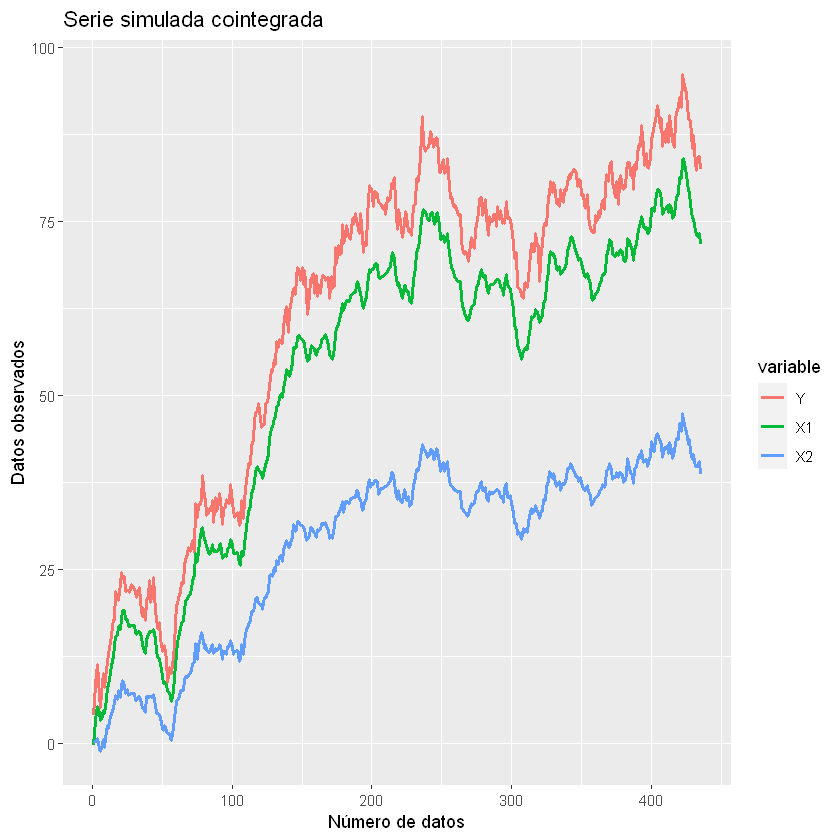

In [6]:
n1t <- c()


# Generación de las gráficas
Data_G = matrix(data = NA, nrow = (N - 1), ncol = 4)
Data_G[, 1] = seq(1, (N - 1), 1)
Data_G[, 2 : 4] = cbind(Y, X1, X2)
colnames(Data_G) = c('N', 'Y', 'X1', 'X2')
Data_G = data.frame(Data_G)
Data_G2 = melt(Data_G, id.vars = 'N')

Graph <- ggplot(data = Data_G2, mapping = aes(x = N, y = value, color = variable)) +
    geom_line(size = 1) + 
    labs(title = 'Serie simulada cointegrada', x = 'Número de datos', y = 'Datos observados') 

# Salidas
head(Data_G)
Graph


head(Data_G2, 20)

### 1. Importando datos

In [14]:
# Importando archivo .csv
File = read.csv(file = ('../Ejercicio inflación/Inflación.csv'), skip = 0, header = TRUE)
head(File)
sprintf('El número de observaciones son: %s', length(File[, 1]))

# Definición de variables
Y = File[, 2]
X1 = File[, 3]
X2 = File[, 4]
N = length(Y)

# Generación de las gráficas
Data_G = matrix(data = NA, nrow = N, ncol = 4)
Data_G[, 1] = seq(1, N, 1)
Data_G[, 2 : 4] = cbind(Y, X1, X2)
colnames(Data_G) = c('N', 'Y', 'X1', 'X2')
Data_G = data.frame(Data_G)
Data_G2 = melt(Data_G, id.vars = 'N')

Graph <- ggplot(data = Data_G2, mapping = aes(x = N, y = value, color = variable)) +
    geom_line(size = 1) + 
    labs(title = 'Serie simulada cointegrada', x = 'Número de datos', y = 'Datos observados') 

# Salidas
head(Data_G)
Graph

,Fecha,Inflacion
,<chr>,<dbl>
1,1/31/2001,8.4922
2,2/28/2001,8.0583
3,3/31/2001,7.8143
4,4/30/2001,7.9759
5,5/31/2001,7.8654
6,6/30/2001,7.9298


[1] "El número de observaciones son: 216"

ERROR: Error in `[.data.frame`(File, , 3): undefined columns selected


### 2. Prueba de raíz unitaria (Dickey Fuller Aumentado) para cada una de las variables
- Prueba Tau ~ Tau para Y, X1 y X2.
- Prueba Tau ~ Tau para Y, X1 y X2.
- Prueba Tau para Y, X1 y X2.
- **Importante:** El P es dado.

In [15]:
# Función de rezago
Rezago = function(Data, Rezago){
    Rezago = Data[1 : (T - Rezago)]
    return(Rezago)
}

# Función de diferencia
Diferencia = function(Data){
Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
    for(i in 1: (T - 1)){
        Serie.dif[i] <- Data[i + 1] - Data[i]
    }
    return(Serie.dif)
}

#### 2.1 La variable Y
- Se selecciona el P óptimo que cumple parsimonia (significancia y ruido blanco) para poder hacer la prueba de raíz unitaria por Dickey - Fuller Aumentado buscando que la serie sea I(1).

In [16]:
P_opt(Data = Y, alpha = 0.05, Spam = 12)

   P Lj.Bx Parsimonia          Check
1 48     1          0 P. innecesario
2 47     1          0 P. innecesario
3 46     1          0 P. innecesario
4 45     1          0 P. innecesario
5 44     1          1   P. necesario


[1] "El parámetro P necesario para hacer la prueba es P = 44."

In [17]:
ATau.T(Data = Y, P = 41, alpha = 0.05)

ERROR: Error in ATau.T(Data = Y, P = 41, alpha = 0.05): could not find function "ATau.T"


In [18]:
ATau.M(Data = Y, P = 41, alpha = 0.01)

ERROR: Error in ATau.M(Data = Y, P = 41, alpha = 0.01): could not find function "ATau.M"


In [19]:
ATau(Data = Y, P = 41, alpha = 0.05)

ERROR: Error in ATau(Data = Y, P = 41, alpha = 0.05): could not find function "ATau"


#### 2.2 La variable X1
- Se selecciona el P óptimo que cumple parsimonia (significancia y ruido blanco) para poder hacer la prueba de raíz unitaria por Dickey - Fuller Aumentado buscando que la serie sea I(1).

In [20]:
P_opt(Data = X1, alpha = 0.05, Spam = 12)

ERROR: Error in P_opt(Data = X1, alpha = 0.05, Spam = 12): object 'X1' not found


In [21]:
ATau.T(Data = X1, P = 20, alpha = 0.05)

ERROR: Error in ATau.T(Data = X1, P = 20, alpha = 0.05): could not find function "ATau.T"


In [22]:
ATau.M(Data = X1, P = 20, alpha = 0.05)

ERROR: Error in ATau.M(Data = X1, P = 20, alpha = 0.05): could not find function "ATau.M"


In [23]:
ATau(Data = X1, P = 20, alpha = 0.05)

ERROR: Error in ATau(Data = X1, P = 20, alpha = 0.05): could not find function "ATau"


#### 2.3 La variable X2
- Se selecciona el P óptimo que cumple parsimonia (significancia y ruido blanco) para poder hacer la prueba de raíz unitaria por Dickey - Fuller Aumentado buscando que la serie sea I(1).

In [24]:
P_opt(Data = X2, alpha = 0.05, Spam = 12)

ERROR: Error in P_opt(Data = X2, alpha = 0.05, Spam = 12): object 'X2' not found


In [25]:
ATau.T(Data = X2, P = 20, alpha = 0.05)

ERROR: Error in ATau.T(Data = X2, P = 20, alpha = 0.05): could not find function "ATau.T"


In [26]:
ATau.M(Data = X2, P = 20, alpha = 0.05)

ERROR: Error in ATau.M(Data = X2, P = 20, alpha = 0.05): could not find function "ATau.M"


In [27]:
ATau(Data = X2, P = 20, alpha = 0.05)

ERROR: Error in ATau(Data = X2, P = 20, alpha = 0.05): could not find function "ATau"


### 3. Prueba de cointegración sobre los residuales del modelo por OLS
- Se realiza una estimación por OLS de las variables conjuntas para obtener las perturbaciones estimadas, con ello se realiza la prueba de Dickey - Fuller Aumentada sobre lo estimado buscando que las perturbaciones sean I(0).
- Si las perturbaciones son I(0), significa que existe un vector de cointegración.
- Si las perturbaciones son I(1), significa que las variables de la serie no están cointegradas.

,T,At
,<dbl>,<dbl>
1,1,4.584890
2,2,2.916056
3,3,2.336020
4,4,2.712507
5,5,-1.424514
6,6,-2.028008


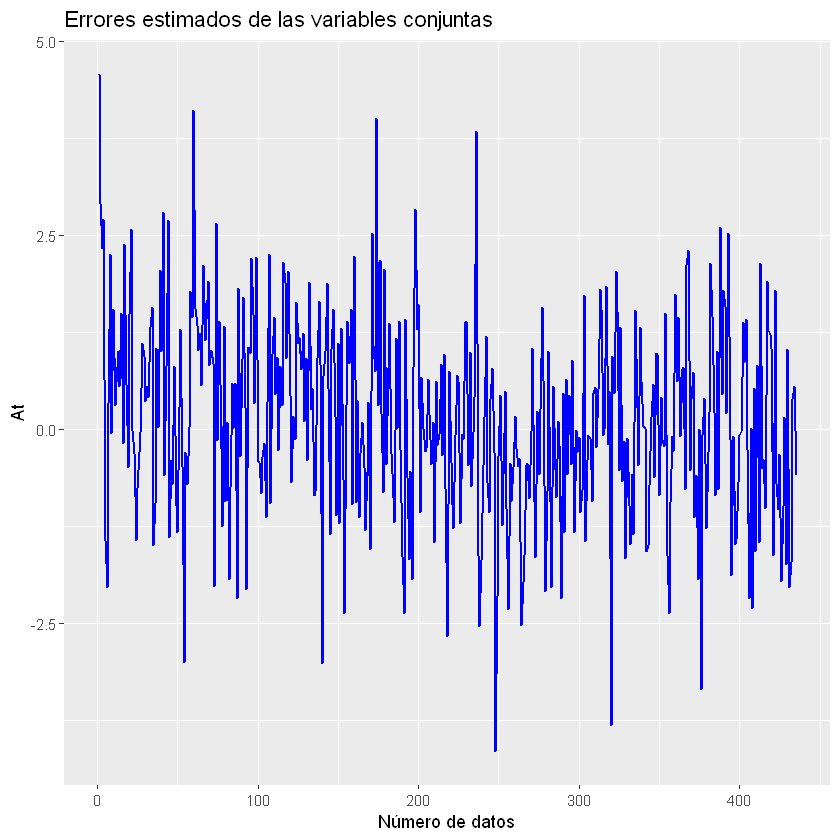

In [30]:
Y = Y
X = cbind(X1, X2)
Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)
At.C = Y - (X %*% Coeff)

N.At = length(At.C)
At.G = matrix(data = NA, ncol = 2, nrow = N.At)
colnames(At.G) = c('T', 'At')
At.G[, 1] = seq(1, N.At, 1)
At.G[, 2] = At.C
At.G = data.frame(At.G)

Graph <- ggplot(data = At.G, mapping = aes(x = T, y = At)) +
    geom_line(size = 0.7, color = 'blue') + 
    labs(title = 'Errores estimados de las variables conjuntas', x = 'Número de datos', y = 'At')

head(At.G)
Graph

In [31]:
P_opt(Data = At.C, alpha = 0.05, Spam = 12)

   P Lj.Bx Parsimonia        Check
1 48     1          1 P. necesario


[1] "El parámetro P necesario para hacer la prueba es P = 48."

In [ ]:
ATau(Data = At.C, P = 48, alpha = 0.05)

### 4. Aplicando el sistema MCE.
$$
\left[\begin{matrix}
\Delta{Y_t} \\
\Delta{X1_t} \\
\Delta{X2_t} \\
\end{matrix}\right]

=

\left[\begin{matrix}
\alpha_{Y_t} \\
\alpha_{X1_t} \\
\alpha_{X2_t} \\
\end{matrix}\right]

+

\left[\begin{matrix}
a_{11,1} \qquad a_{12,1} \qquad a_{13,1}\\
a_{21,1} \qquad a_{22,1} \qquad a_{23,1}\\
a_{31,1} \qquad a_{32,1} \qquad a_{33,1}\\
\end{matrix}\right]

\left[\begin{matrix}
\Delta{Y_{t-1}} \\
\Delta{X1_{t-1}} \\
\Delta{X2_{t-1}} \\
\end{matrix}\right]

+ \dots +

\left[\begin{matrix}
a_{11,p} \qquad a_{12,p} \qquad a_{13,p}\\
a_{21,p} \qquad a_{22,p} \qquad a_{23,p}\\
a_{31,p} \qquad a_{32,p} \qquad a_{33,p}\\
\end{matrix}\right]

\left[\begin{matrix}
\Delta{Y_{t-p}} \\
\Delta{X1_{t-p}} \\
\Delta{X2_{t-p}} \\
\end{matrix}\right]

- 

\left[\begin{matrix}
\alpha_{1} \\
\alpha_{2} \\
\alpha_{3} \\
\end{matrix}\right]

\left[\begin{matrix}
\epsilon_{t-1} 
\end{matrix}\right]

+

\left[\begin{matrix}
\eta_{1t} \\
\eta_{2t} \\
\eta_{3t} \\
\end{matrix}\right]
$$

$$
\Delta{Y_t} = \alpha_{Y_t} + a_{11,1} * \Delta{Y_{t-1}} + a_{12,1} * \Delta{X1_{t-1}} + a_{13,1} * \Delta{X2_{t-1}} + \dots + a_{11,p} * \Delta{Y_{t-p}} + a_{12,p} * \Delta{X1_{t-p}} + a_{13,p} * \Delta{X2_{t-p}} - \alpha_{1} * \epsilon_{t-1} + \eta_{1t}
$$º

In [32]:
# Construcción de la matriz de información
Data = cbind(Y, X1, X2)
head(Data)
tail(Data)

4.048947,-0.1804401,0.1958716
8.351534,3.3258294,0.3731594
10.042665,4.6385037,0.4076207
11.445853,5.4088116,0.7022644
6.959657,4.3406112,-0.6697648
5.185382,3.4026673,-1.0996739


"[430,]",87.33639,75.38992,41.54877
"[431,]",83.24120,73.72862,39.84886
"[432,]",82.35710,73.14095,40.01225
"[433,]",83.98406,72.76163,39.82978
"[434,]",84.33952,73.31268,40.53381
"[435,]",82.43856,71.69242,38.65181


- Revisar linea 101 del código, quitar abs().

In [13]:
MCE = function(Data, alpha = 0.05, Spam = 12){
    T = length(Data[, 1])
    C = ncol(Data)

    # Función de rezago
    Rezago = function(Data, Rezago ){
        Rezago = Data[1 : (T - Rezago)]
        return(Rezago)
    }

    # Función de diferencia
    Diferencia = function(Data){
        Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
        for(i in 1: (T - 1)){
            Serie.dif[i] <- Data[i + 1] - Data[i]
        }
        return(Serie.dif)
    }

    # Función de Parsimonio
    Parsimonio = function(Delta, Delta.var){
        Desv = sqrt(Delta.var)
        Vec = Delta
        for (i in 1 : length(Delta)){
            LS = Delta[i] + (2 * Desv[i])
            LI = Delta[i] - (2 * Desv[i])
            if (LS > 0 & LI > 0 || LS < 0 & LI < 0){
                Vec[i] = 1
            } else {
                Vec[i]= 0
            }
        }
        Vec = sum(Vec)
        Vec
    }

    # Función de Ljung - Box
    L.B = function(At, K, AR_P){
        t = AR_P + 1
        T = length(At)    
        Rho_at = matrix(data = NA, nrow = (T - K), ncol = 1)
        for (i in 1 : (T - K)){
            Rho_at[i] = sum(At[i] * At[(i + t)]) / sum(At ** 2)
        }

        # Prueba de Ljung - Box
        Q = (T - AR_P) * (T - AR_P + 2) * (sum((sum(Rho_at) ** 2) / (T - AR_P - K))) 
        Vc = qchisq(p = alpha, df = (T - AR_P))

        # Salida
        if (Q < Vc){
            1
        } else {
            0
        } 
    }
    
    # Creación de la matriz P óptimo
    P.I = 4 * Spam                                                                          # ¿Cambiar a T / 4?
    P_est = matrix(data = NA, nrow = P.I, ncol = 6)
    colnames(P_est) = c('P', 'Lj-Bx', 'Significancia', 'Alpha1', 'C. Alpha1', 'Conclusión')
    P_est[, 1] = c(1 : P.I)

    # Diferenciación de la matriz de datos
    Data.Diff = matrix(data = NA, nrow = (T - 1), ncol = C)
    for (i in 1 : C){
        Data.Diff[, i] = Diferencia(Data[, i])
    }

    # Residuales del modelo con las variables conjuntas
    Y1 = Data[, 1]
    X1 = Data[, 2 : C]
    Coeff1 = solve(t(X1) %*% X1) %*% (t(X1) %*% Y1)
    At.C = Y1 - (X1 %*% Coeff1)

    # Halla el P óptimo
    for (p in 1 : P.I){
        P = P_est[p, 1]                                     
        Data.d.r = matrix(data = NA, nrow = (T - 1), ncol = (C * P))
        for (i in 1 : P){
            Data.d.r[(1 : (nrow(Data.d.r) - i)), (((i - 1) * C) + 1) : (((i - 1) * C) + C)] = Data.Diff[((i + 1) : nrow(Data.d.r)), ]
        }
        Data.d.r = Data.d.r[-((T - P) : T), ]

        # Estimación por OLS
        Y = Data[(1 : (T - P - 1)), 1]
        X = cbind(1, Data.d.r, At.C[1 : (T - P - 1)])
        Coeff = solve(t(X) %*% X, tol = 0) %*% (t(X) %*% Y)

        Ym = X %*% Coeff
        Em = Y - Ym
        
        Sigma2 = as.numeric((t(Em) %*% Em) / (T - ((P * C) - 2)))
        Var.cov = (Sigma2 * solve(t(X) %*% X, tol = 0))
        P_est = data.frame(P_est)
        
        # Construcción de vectores para prueba de parsimonia
        L.C = length(Coeff)
        Diag = diag(Var.cov)
        Beta = matrix(data =  Coeff[(L.C - C) : (L.C - 1)], nrow = C, ncol = 1)
        Var.Beta = matrix(data =  abs(Diag[(L.C - C) : (L.C - 1)]), nrow = C, ncol = 1)                 ##################### Quitar abs()

        # Prueba de significancia alpha
        if (Coeff[L.C] < 0){
            Signo = 1
        } else {
            Signo = 0
        }
        Alpha = Coeff[L.C]
        Var.Alpha = Diag[L.C : L.C]
        Stat.Alpha = Alpha / sqrt(Var.Alpha)
        Vca = qt(p = alpha, df = (T - P - 1), lower.tail = TRUE)

        if (Signo == 1){
            if (Stat.Alpha < Vca){
                P_est[P, 5] = sprintf('El alpha es significativo y negativo a un alpha del %s', alpha)
                Sig = 1
            } else {
                P_est[P, 5] = sprintf('El alpha no es significativo y negativo a un alpha del %s', alpha)
                Sig = 0
            }
        } else {
            P_est[P, 5] = ('El signo del coeficiente alpha no es negativo.')
            Sig = 0
        }

        # Pruebas para obtener el P óptimo
        P_est[P, 2] = L.B(At = Em, K = length(Coeff), AR_P = P)
        P_est[P, 3] = Parsimonio(Delta = Beta, Delta.var = Var.Beta)
        P_est[P, 4] = Signo + Sig
        Check = P_est[P, 3] + P_est[P, 4] # + P_est[P, 2]
        if (Check >= 3){
            P_est[P, 6] = 'P. Necesario'
            break
        } else {
            P_est[P, 6] = 'P. Innecesario'
        }
    }

    # P óptimo
    P = P

    # Estimación del parámetro Omega                                 
    Delta = matrix(data = NA, nrow = (T - 1), ncol = (C * P))
    for (i in 1 : P){
        Delta[(1 : (nrow(Delta) - i)), (((i - 1) * C) + 1) : (((i - 1) * C) + C)] = Data.Diff[((i + 1) : nrow(Delta)), ]
    }
    Delta = Delta[-((T - P) : T), ]

    Y = Data[(1 : (T - P - 1)), 1]
    X = cbind(1, Delta, At.C[1 : (T - P - 1)])
    Coeff.I = solve(t(X) %*% X, tol = 0) %*% (t(X) %*% Y)
    L.C = length(Coeff.I)

    Ym = X %*% Coeff
    Em = Y - Ym
        
    Sigma2 = as.numeric((t(Em) %*% Em) / (T - ((P * C) - 2)))
    Var.cov = (Sigma2 * solve(t(X) %*% X, tol = 0))

    # Parámetros
    Alpha.R = Coeff.I[L.C]
    Coeff.R =  c(1, Coeff[(L.C - C + 1) : (L.C - 1)])

    Omega = matrix(data = 0, nrow = C, ncol = 1)
    for (i in 2 : C){
        Y = Em
        X = Alpha.R * Data[(1 : length(Em)), i]
        Omega[i] = solve(t(X) %*% X, tol = 0) %*% (t(X) %*% Y)
    }

    # Vector de cointegración
    V.CI = matrix(data = Coeff.R + Omega, nrow = C, ncol = 1)
    colnames(V.CI) = c('V. Cointegración')

    # Salidas
    print(V.CI)
    print(sprintf('El parámetro P necesario para hacer la prueba es P = %s.', P)) 
    return(P_est[(1 : P), ])
}

MCE(Data = Data, alpha = 0.05, Spam = 1)

     V. Cointegración
[1,]         1.000000
[2,]        -5.877307
[3,]         3.420719
[1] "El parámetro P necesario para hacer la prueba es P = 1."


,P,Lj.Bx,Significancia,Alpha1,C..Alpha1,Conclusión
,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,1,0,1,2,El alpha es significativo y negativo a un alpha del 0.05,P. Necesario
